# **INSTALLING DEPENDENCIES**

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

In [ ]:
!pip install lxml

# **IMPORTING ESSENTIAL LIBRARIES**

In [ ]:
from collections import OrderedDict
from typing import List, Tuple, Dict
import numpy as np

from datasets.utils.logging import disable_progress_bar

import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, Grayscale, RandomHorizontalFlip, RandomRotation
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST
import torch.nn as nn
import torch.nn.functional as F
import csv
import copy
import os

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import MDS  # Optional for visualization

import xml.etree.ElementTree as ET
from lxml import etree


import logging
from datetime import datetime

import random
import matplotlib.pyplot as plt

In [ ]:
!mkdir models

# **LOG FILE**

In [ ]:
import logging
from datetime import datetime
import shutil

log_path = datetime.now().strftime("%Y-%m-%d_%H-%M-%S_")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

log_file = log_path + '.log'
os.mkdir(log_path)
open(log_file, 'a').close()

# **PARSE .XML FILE**

In [ ]:
def parse_xml_assignments(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    node_assignments = {}
    for node in root.findall('Node'):
        node_id = int(node.get('id'))
        shards = [(int(dp.get('classLabel')), int(dp.get('shard'))) for dp in node.findall('DataPair')]
        node_assignments[node_id] = shards
    return node_assignments

from google.colab import files
uploaded = files.upload()

Saving shards.xml to shards.xml


# **DATA AUGMENTATION**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


def chunk(a, i, n):
    a2 = chunkify(a, n)
    return a2[i]

def chunkify(a, n):
    # splits list into even size list of lists
    # [1,2,3,4] -> [1,2], [3,4]

    k, m = divmod(len(a), n)
    gen = (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
    return list(gen)

def augment_dataset_with_rotation(dataset):
  def rotate_90(image):
    return transforms.functional.rotate(image, 90)
  def rotate_180(image):
    return transforms.functional.rotate(image, 180)
  def rotate_270(image):
    return transforms.functional.rotate(image, 270)
  original_images = []
  rotated_images = []
  original_labels = []
  rotated_labels = []

  for img, label in dataset:
    original_images.append(img)
    rotated_images.append(rotate_180(img))
    original_labels.append(label)
    rotated_labels.append(label)

  original_dataset = torch.utils.data.TensorDataset(torch.stack(original_images), torch.tensor(original_labels))
  rotated_dataset = torch.utils.data.TensorDataset(torch.stack(rotated_images), torch.tensor(rotated_labels))
  augmented_dataset = ConcatDataset([original_dataset, rotated_dataset])

  show_images(original_dataset)
  show_images(rotated_dataset)

  return augmented_dataset

def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15,5))
    for i in range(num_images):
      img, label = dataset[i]
      img = img.squeeze().numpy()
      axes[i].imshow(img, cmap='gray')
      axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')

    plt.show()

class ClusteredDataset:
  def __init__(self):

    self.dataset = {}

    self.transform = Compose([
      Resize((224,224)),
      ToTensor(),
      Normalize((0.5,), (0.5,)),
      ])

    '''
    self.transform = Compose([
      ToTensor(),
      Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])
      '''

  def load_dataset(self, dataset: str, train):
    if dataset == 'mnist':
      if train:
        train = MNIST(root= './data', train= True, download= True, transform= self.transform)

        #dl_train = DataLoader(train)
        X = train.data.unsqueeze(1).float() # (60000,28, 28)
        Y = train.targets #(60000)
        #X = X / 255.0
      else:
        test = MNIST(root= './data', train= False, download= True, transform= self.transform)
        #dl_test = DataLoader(test)
        X = test.data.unsqueeze(1).float() # (60000,28, 28)
        print("S", X.shape)
        Y = test.targets #(60000)
        #X = X / 255.0

    if dataset == 'cifar10':
      if train:
        train = CIFAR10(root= './data', train= True, download= True, transform= self.transform)
        dl_train = DataLoader(train)
        X = dl_train.dataset.data # (60000,28, 28)
        Y = dl_train.dataset.targets #(60000)
        #X = X / 255.0
      else:
        test = CIFAR10(root= './data', train= False, download= True, transform= self.transform)
        dl_test = DataLoader(test)
        X = dl_test.dataset.data # (60000,28, 28)
        Y = dl_test.dataset.targets #(60000)
        #X = X / 255.0

    return X, Y

  def setup_dataset(self, num_dataset, num_clients, num_data_per_client, num_clusters, random=True):
    assert (num_clients // num_clusters) * num_data_per_client == num_dataset
    data_indices = []
    cluster_assignments = []
    client_per_cluster = num_clients // num_clusters
    for c_i in range(num_clusters):
      if random:
        ll = list(np.random.permutation(num_dataset))
      else:

        ll = list(range(num_dataset))

      ll2 = chunkify(ll, client_per_cluster) # splits ll into m lists with size n
      data_indices += ll2

      cluster_assignments += [c_i for _ in range(client_per_cluster)]

    data_indices = np.array(data_indices)
    cluster_assignments = np.array(cluster_assignments)
    assert data_indices.shape[0] == cluster_assignments.shape[0]
    assert data_indices.shape[0] == num_clients


    return data_indices, cluster_assignments

  def rotate_data(self, num_dataset, num_clusters, m_i):


    indices = self.dataset['data_indices'][m_i]
    c_i = self.dataset['cluster_assign'][m_i]


    X_batch = self.dataset['X'][indices]

    Y_batch = self.dataset['Y'][indices]

    #print("shape", X_batch.shape, Y_batch.shape)


    if num_clusters == 4:
      k = c_i
    if num_clusters == 2:
      k = (c_i % 2) * 2
    if num_clusters == 1:
      k = 0

    X_batch2 = torch.rot90(X_batch, k=int(k), dims = (1,2))
    X_batch3 = X_batch2.reshape(-1,1, 28, 28)
    print("after", X_batch3.shape)


    return X_batch3, Y_batch




  def get_loaders(self, num_dataset, num_clients, num_data_per_client, num_clusters,train):
    if train:
      self.dataset['data_indices'], self.dataset['cluster_assign'] = self.setup_dataset(num_dataset, num_clients, num_data_per_client, num_clusters)
      X, Y = self.load_dataset('mnist', train)
      self.dataset['X'] = X
      self.dataset['Y'] = Y
    else:
      self.dataset['data_indices'], self.dataset['cluster_assign'] = self.setup_dataset(num_dataset, num_clients, num_data_per_client, num_clusters)
      X, Y = self.load_dataset('mnist', train)
      self.dataset['X'] = X
      self.dataset['Y'] = Y


    loaders = []
    for client in range(num_clients):
      X_label, Y_label = self.rotate_data(num_dataset, num_clusters, client)
      if isinstance(X_label, np.ndarray):
        X_label = torch.tensor(X_label, dtype=torch.float32)
      if isinstance(Y_label, np.ndarray):
        Y_label = torch.tensor(Y_label, dtype=torch.long)
      dataset = TensorDataset(X_label, Y_label)
      data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
      loaders.append(data_loader)
    return loaders










# **PREPARING THE CIFAR10 DATA**

In [ ]:

import random
class Dataset:
  def __init__(self):
    self.num_classes = 10
    self.num_shards_per_class = 4

    self.transform = Compose([
      ToTensor(),
      Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
      ])


    """
    self.transform = Compose([
      #Resize(224),
      Grayscale(num_output_channels=3),
      ToTensor(),
      Normalize((0.1307,), (0.3081,)),
      ])
      """

  def load_CIFAR10_dataset(self):

    ## For Alexnet model
    """
    tr = Compose([Resize(224),
                             ToTensor(),
                             Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.25))])
    """
    train = CIFAR10(root= './data', train= True, download= True, transform=self.transform)
    test = CIFAR10(root= './data', train= False, download= True, transform=self.transform)
    return train, test

  def load_MNIST_dataset(self):
    train = MNIST(root= './data', train= True, download= True, transform= self.transform)
    test = MNIST(root= './data', train= False, download= True, transform= self.transform)
    return train, test

  def load_FashionMNIST_dataset(self):
    train = FashionMNIST(root= './data', train= True, download= True, transform= self.transform)
    test = FashionMNIST(root= './data', train= False, download= True, transform= self.transform)
    return train, test

  def load_shards_from_xml_file(self, xml_file, train, test, num_clients):
    node_assignments = parse_xml_assignments(xml_file)
    train_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    test_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    train_shards, _ = self.divide_class_into_shards(train, 10, 20)
    test_shards, _ = self.divide_class_into_shards(test, 10, 20)
    trainLoaders = []
    testLoaders = []
    for node in range(num_clients):
      shard_ids = node_assignments[node]
      indices_tr = [(shard_id[0] - 1) * 20 + shard_id[1] for shard_id in shard_ids]
      indices_ts = [(shard_id[0] - 1) * 20 + random.randint(1,19) for shard_id in shard_ids]
      train_indices = np.concatenate([train_shards[idx] for idx in indices_tr])
      test_indices = np.concatenate([test_shards[idx] for idx in indices_ts])
      train_loader = DataLoader(Subset(train, train_indices), batch_size=64, shuffle=True)
      trainLoaders.append(train_loader)
      test_loader = DataLoader(Subset(test, test_indices), batch_size=64, shuffle=True)
      testLoaders.append(test_loader)

    return trainLoaders, testLoaders


    return 1

  def divide_class_into_shards(self, dataset, num_classes: int, num_shards_per_class: int):
    num_shards = num_classes * num_shards_per_class

    num_imgs = int(len(dataset)/ num_shards_per_class / num_classes)

    ## Create a list to store indices for each class
    class_indices = [[] for _ in range(num_classes)]
    labels = np.array(dataset.targets)


    # Group the indices of each class
    for idx, label in enumerate(labels):
      class_indices[label].append(idx)


    # Shuffle indices within each class

    for i in range(num_classes):
      np.random.shuffle(class_indices[i])

    shards = []
    for i in range(num_classes):
      for j in range(num_shards_per_class):

        shards.append(class_indices[i][j*num_imgs:(j+1)*num_imgs])
    shards = np.array(shards, dtype='object')

    return shards, num_shards
  def noniid_split(self, dataset, num_classes: int, num_clients: int, num_shards_per_class: int):

    shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
    ## Ensure each client gets 2 shards from different classes
    client_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    shards_per_client = 4
    shards_assignments = np.zeros(num_shards, dtype=bool)
    classes = []
    for client in range(num_clients):
      assigned_shards = []
      classes_assigned = []

      while len(assigned_shards) < shards_per_client:
        shard_idx = np.random.choice(np.where(shards_assignments == False)[0])
        class_idx = shard_idx // num_shards_per_class
        if class_idx not in classes_assigned:
          assigned_shards.append(shard_idx)
          classes_assigned.append(class_idx)
          shards_assignments[shard_idx] = True

      classes.append(classes_assigned)
      print(classes_assigned)

      for shard in assigned_shards:
        client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)
    return client_data_indices, classes


  def partition_test_data_based_on_train(self, dataset, train_idx, num_classes: int, num_clients: int, num_shards_per_class: int):

    shards, num_shards = self.divide_class_into_shards(dataset, num_classes, num_shards_per_class)
    ## Ensure each client gets 2 shards from different classes
    client_data_indices = {i: np.array([], dtype='int64') for i in range(num_clients)}
    shards_per_client = 4
    shards_assignments = np.zeros(num_shards, dtype=bool)
    classes = []
    for client in range(num_clients):
      assigned_shards = []
      classes_assigned = []

      while len(assigned_shards) < shards_per_client:
        class_idx = train_idx[client][len(assigned_shards)]
        #shard_idx = np.random.choice(np.where(shards_assignments == False)[0])
        shard_idx = class_idx * 20 + random.randint(1,19)
        print("shard, class", shard_idx, class_idx)
        assigned_shards.append(shard_idx)
        classes_assigned.append(class_idx)
        #if class_idx not in classes_assigned:
          #assigned_shards.append(shard_idx)
          #classes_assigned.append(class_idx)
          #shards_assignments[shard_idx] = True

      classes.append(classes_assigned)
      print(classes_assigned)

      for shard in assigned_shards:
        client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)
    return client_data_indices
  def get_dataloaders(self, dataset, indices, batch_size):
    loaders = []
    for client_idx in indices:
      subset = Subset(dataset, indices[client_idx])
      loader = DataLoader(subset, batch_size=batch_size, shuffle= True)
      loaders.append(loader)
    return loaders






# **DATA DISTRIBUTION**

In [ ]:
import logging
import random
from torchvision import datasets, transforms
import numpy as np
import random
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, Grayscale, RandomHorizontalFlip, RandomRotation
from torchvision.datasets import CIFAR10, MNIST, FashionMNIST
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset

def uniform(N, k):
    """Uniform distribution of 'N' items into 'k' groups."""
    dist = []
    avg = N / k
    # Make distribution
    for i in range(k):
        dist.append(int((i + 1) * avg) - int(i * avg))
    # Return shuffled distribution
    random.shuffle(dist)
    return dist

def normal(N, k):
    """Normal distribution of 'N' items into 'k' groups."""
    dist = []
    # Make distribution
    for i in range(k):
        x = i - (k - 1) / 2
        dist.append(int(N * (np.exp(-x) / (np.exp(-x) + 1)**2)))
    # Add remainders
    remainder = N - sum(dist)
    dist = list(np.add(dist, uniform(remainder, k)))
    # Return non-shuffled distribution
    return dist


class Generator():  # CHECKME
    """Generator for UNNAMED dataset."""

    # Extract UNNAMED data using torchvision datasets
    def read(self, path):
        self.trainset = FashionMNIST(
            path, train=True, download=True, transform=transforms.Compose([
                ToTensor(),
                Normalize((0.5,), (0.5,)),
      ]))
        self.testset = FashionMNIST(
            path, train=False, download= True, transform=transforms.Compose([
                ToTensor(),
                Normalize((0.5,), (0.5,)),
      ]))
        self.labels = list(self.trainset.classes)
    def group(self):

        # Create empty dict of labels
      grouped_data = {label: [] for label in self.labels}  # pylint: disable=no-member

        # Populate grouped data dict
      for datapoint in self.trainset:
          # pylint: disable=all

          _, label = datapoint
          label = self.labels[label]

          grouped_data[label].append(datapoint)


      return grouped_data

    def group_test(self):
        # Create empty dict of labels
      grouped_data = {label: [] for label in self.labels}  # pylint: disable=no-member

        # Populate grouped data dict
      for datapoint in self.testset:
        _, label = datapoint
        label = self.labels[label]
        grouped_data[label].append(datapoint)

      return grouped_data
'''
class Generator(object):
  def read(self, path):
        # Read the dataset, set: trainset, testset, labels
    raise NotImplementedError

    # Group the data by label
  def group(self):
        # Create empty dict of labels
    grouped_data = {label: [] for label in self.labels}  # pylint: disable=no-member

        # Populate grouped data dict
    for datapoint in self.trainset:  # pylint: disable=all
        _, label = datapoint  # Extract label
        label = self.labels[label]

        grouped_data[label].append(datapoint)

    self.trainset = grouped_data  # Overwrite trainset with grouped data

    # Run data generation
  def generate(self, path):
    self.read(path)
    self.trainset_size = len(self.trainset)  # Extract trainset size
    self.group()

    return self.trainset
'''
class Loader(object):
  def __init__(self, generator):
    self.trainset = generator.group()
    self.testset = generator.group_test()
    self.labels = generator.labels
    self.trainset_size = 50000
    self.used = {label: [] for label in self.labels}
    self.used_test = {label: [] for label in self.labels}

  def extract(self, label, n):
    #print(label, n)
    if len(self.trainset[label]) > n:

        extracted = self.trainset[label][:n]  # Extract data
        self.used[label].extend(extracted)  # Move data to used
        del self.trainset[label][:n]  # Remove from trainset
        return extracted
    else:
        logging.warning('Insufficient data in label: {}'.format(label))
        logging.warning('Dumping used data for reuse')

        # Unmark data as used
        for label in self.labels:
            self.trainset[label].extend(self.used[label])
            self.used[label] = []

        # Extract replenished data
        return self.extract(label, n)

  def extract_test(self, label, n):
    #print(label, n)
    if len(self.testset[label]) > n:
      extracted = self.testset[label][:n]  # Extract data
      self.used_test[label].extend(extracted)  # Move data to used
      del self.testset[label][:n]  # Remove from trainset
      return extracted
    else:
      logging.warning('Insufficient data in label: {}'.format(label))
      logging.warning('Dumping used data for reuse')

        # Unmark data as used
      for label in self.labels:
          self.testset[label].extend(self.used_test[label])
          self.used_test[label] = []

        # Extract replenished data
      return self.extract_test(label, n)


  def get_partition(self, partition_size):
    # Get an partition uniform across all labels

    # Use uniform distribution
    dist = dists.uniform(partition_size, len(self.labels))

    partition = []  # Extract data according to distribution
    for i, label in enumerate(self.labels):
        partition.extend(self.extract(label, dist[i]))

    # Shuffle data partition
    random.shuffle(partition)

    return partition

  def get_testset(self):
    # Return the entire testset
    return self.testset


class BiasLoader(Loader):


  def get_partition(self, partition_size, bias, pref):
    #print("in partition")
    # Get a non-uniform partition with a preference bias

    # Calculate sizes of majorty and minority portions
    majority = int(partition_size[0] * bias)
    minority = partition_size[0] - majority

    majority_test = int(partition_size[1] * bias)
    minority_test = partition_size[1] - majority_test

    # Calculate number of minor labels
    len_minor_labels = len(self.labels) - 1
    secondary = False

    if secondary:
        # Distribute to random secondary label
        dist = [0] * len_minor_labels
        dist[random.randint(0, len_minor_labels - 1)] = minority
    else:
        # Distribute among all minority labels
        dist = uniform(minority, len_minor_labels)
        dist_test = uniform(minority_test, len_minor_labels)

    # Add majority data to distribution
    dist.insert(self.labels.index(pref), majority)
    dist_test.insert(self.labels.index(pref), majority_test)
    #print("done")

    partition = []  # Extract data according to distribution
    partition_test = []
    for i, label in enumerate(self.labels):
        #print(dist[i], label)
        partition.extend(self.extract(label, dist[i]))
        partition_test.extend(self.extract_test(label, dist_test[i]))
        #print(partition)

    # Shuffle data partition
    random.shuffle(partition)
    random.shuffle(partition_test)

    return partition, partition_test


class ShardLoader(Loader):
  def create_shards(self):
    total = self.num_clients * self.data_per_client
    shard_size = int(self.trainset_size / total)

    data = []
    for _, items in self.trainset.items():
            data.extend(items)

    shards = [data[(i * shard_size):((i + 1) * shard_size)] for i in range(total)]
    random.shuffle(shards)
    self.shards = shards
    self.used = []

    logging.info('Created {} shards of size {}'.format(len(shards), shard_size))
  def extract_shard(self):
    shard = self.shards[0]
    self.used.append(shard)
    del self.shards[0]
    return shard
  def get_partition(self):

    partition = []
    for i in range(self.shard_per_client):
        partition.extend(self.extract_shard())
    random.shuffle(partition)

    return partition




def make_loaders(IID, bias, loader_type, num_clients):
  generator = Generator()
  data_path = './data'
  generator.read(data_path)
  labels = generator.labels

  loader = {
        'basic': Loader(generator),
        'bias': BiasLoader(generator),
        'shard': ShardLoader(generator)
        }
  trainloaders = []
  testloaders = []
  if not IID:
    dist = {
             "uniform": uniform(num_clients, len(labels)),
            "normal": normal(num_clients, len(labels))
            }['uniform']
    random.shuffle(dist)
  for client_id in range(num_clients):
    if not IID:
      if bias:
        #print("here")
        bias = 0.4
        pref = random.choices(labels, dist)[0]
      elif shard:
        print("shard")

    if loader_type != 'shard':
      partition_size = [6000, 1000]
    if loader_type == 'bias':
      data, data_test = loader['bias'].get_partition(partition_size, bias, pref)

      data_loader = DataLoader(data, batch_size=32, shuffle=True)
      data_loader_test = DataLoader(data_test, batch_size=32, shuffle=True)
      trainloaders.append(data_loader)
      testloaders.append(data_loader_test)
  return trainloaders, testloaders

trainloaders, testloaders = make_loaders(False, True, 'bias', 10)


100%|██████████| 26421880/26421880 [00:03<00:00, 7998755.45it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 131692.90it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2491420.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6772985.25it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# **DEFINE THE NEURAL NETWORK MODEL**

In [ ]:

import torchvision.models as models
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=False)

        ## Required for MNIST dataset since it only has one channel insted of 3
        #self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the fully connected layer to match the number of classes
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        #self.resnet18.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.01, training=True))

    def forward(self, x):
      out = self.resnet18(x)
      return out



# **DEFINE THE GOOGLENET MODEL**

In [ ]:
"""

import torchvision.models as models
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.googlenet = models.googlenet()

        # Replace the fully connected layer to match the number of classes
        self.googlenet.fc = nn.Linear(self.googlenet.fc.in_features, num_classes)
        self.googlenet.aux1.fc2 = nn.Linear(self.googlenet.aux1.fc2.in_features, 10)
        self.googlenet.aux2.fc2 = nn.Linear(self.googlenet.aux2.fc2.in_features, 10)


    def forward(self, x):
        return self.googlenet(x)
"""


# **MOBILENET**

In [ ]:

from torchvision.models.mobilenet import mobilenet_v2
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.mobilenet = mobilenet_v2()
        #self.mobilenet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, out_features=10)

        # Replace the fully connected layer to match the number of classes
        #self.mobilenet.fc = nn.Linear(self.mobilenet.fc.in_features, num_classes)


    def forward(self, x):
        return self.mobilenet(x)


# **ALEXNET MODEL**

In [ ]:
"""
import torchvision.models as models
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Load a pre-trained ResNet18 model
        self.alexnet = models.alexnet(pretrained=False)
        # Replace the fully connected layer to match the number of classes
        num_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_features, num_classes)


    def forward(self, x):
        return self.alexnet(x)
"""

'\nimport torchvision.models as models\nclass Net(nn.Module):\n    def __init__(self, num_classes=10):\n        super(Net, self).__init__()\n        # Load a pre-trained ResNet18 model\n        self.alexnet = models.alexnet(pretrained=False)\n        # Replace the fully connected layer to match the number of classes\n        num_features = self.alexnet.classifier[6].in_features\n        self.alexnet.classifier[6] = nn.Linear(num_features, num_classes)\n\n\n    def forward(self, x):\n        return self.alexnet(x)\n'

# **DEFINE THE CNN MODEL**

In [ ]:

class Net(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# **AGGREGATION METHODS**

In [ ]:

def compute_accuracy(model, dataloader, get_confusion_matrix=False, moon_model=False, device="cpu"):

    was_training = False
    if model.training:
        model.eval()
        was_training = True

    true_labels_list, pred_labels_list = np.array([]), np.array([])

    if type(dataloader) == type([1]):
        pass
    else:
        dataloader = [dataloader]

    correct, total = 0, 0
    with torch.no_grad():
        for tmp in dataloader:
            for batch_idx, (x, target) in enumerate(tmp):
                x, target = x.to(device), target.to(device,dtype=torch.int64)
                if moon_model:
                    _, _, out = model(x)
                else:
                    out = model(x)
                _, pred_label = torch.max(out.data, 1)

                total += x.data.size()[0]
                correct += (pred_label == target.data).sum().item()

                if device == "cpu":
                    pred_labels_list = np.append(pred_labels_list, pred_label.numpy())
                    true_labels_list = np.append(true_labels_list, target.data.numpy())
                else:
                    pred_labels_list = np.append(pred_labels_list, pred_label.cpu().numpy())
                    true_labels_list = np.append(true_labels_list, target.data.cpu().numpy())

    if get_confusion_matrix:
        conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)

    if was_training:
        model.train()

    if get_confusion_matrix:
        return correct/float(total), conf_matrix

    return correct/float(total)
def train_net_fedprox(net_id, net, global_net, train_dataloader, test_dataloader, epochs, lr, args_optimizer, mu, device="cpu"):
    logger.info('Training network %s' % str(net_id))
    logger.info('n_training: %d' % len(train_dataloader))
    logger.info('n_test: %d' % len(test_dataloader))

    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Pre-Training Training accuracy: {}'.format(train_acc))
    logger.info('>> Pre-Training Test accuracy: {}'.format(test_acc))


    if args_optimizer == 'adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=args.reg)
    elif args_optimizer == 'amsgrad':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=args.reg,
                               amsgrad=True)
    elif args_optimizer == 'sgd':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

    criterion = nn.CrossEntropyLoss().to(device)

    cnt = 0
    # mu = 0.001
    global_weight_collector = list(global_net.to(device).parameters())

    for epoch in range(epochs):
        epoch_loss_collector = []
        for batch_idx, (x, target) in enumerate(train_dataloader):
            x, target = x.to(device), target.to(device)

            optimizer.zero_grad()
            x.requires_grad = True
            target.requires_grad = False
            target = target.long()

            out = net(x)
            loss = criterion(out, target)

            #for fedprox
            fed_prox_reg = 0.0
            for param_index, param in enumerate(net.parameters()):
                fed_prox_reg += ((mu / 2) * torch.norm((param - global_weight_collector[param_index]))**2)
            loss += fed_prox_reg


            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        logger.info('Epoch: %d Loss: %f' % (epoch, epoch_loss))

        # if epoch % 10 == 0:
        #     train_acc = compute_accuracy(net, train_dataloader, device=device)
        #     test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)
        #
        #     logger.info('>> Training accuracy: %f' % train_acc)
        #     logger.info('>> Test accuracy: %f' % test_acc)

    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Training accuracy: %f' % train_acc)
    logger.info('>> Test accuracy: %f' % test_acc)

    net.to('cpu')
    logger.info(' ** Training complete **')
    return train_acc, test_acc


def train_net_scaffold(net_id, net, global_model, c_local, c_global, train_dataloader, test_dataloader, epochs, lr, args_optimizer, device="cpu"):
    logger.info('Training network %s' % str(net_id))

    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Pre-Training Training accuracy: {}'.format(train_acc))
    logger.info('>> Pre-Training Test accuracy: {}'.format(test_acc))

    if args_optimizer == 'adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=args.reg)
    elif args_optimizer == 'amsgrad':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=args.reg,
                               amsgrad=True)
    elif args_optimizer == 'sgd':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    cnt = 0
    if type(train_dataloader) == type([1]):
        pass
    else:
        train_dataloader = [train_dataloader]

    #writer = SummaryWriter()
    '''
    c_local.to(device)
    c_global.to(device)
    global_model.to(device)

    c_global_para = c_global.state_dict()
    c_local_para = c_local.state_dict()
    '''
    c_global_para = c_global
    c_local_para = c_local
    for epoch in range(epochs):
        epoch_loss_collector = []
        for tmp in train_dataloader:
            for batch_idx, (x, target) in enumerate(tmp):
                x, target = x.to(device), target.to(device)

                optimizer.zero_grad()
                x.requires_grad = True
                target.requires_grad = False
                target = target.long()

                out = net(x)
                loss = criterion(out, target)

                loss.backward()
                optimizer.step()

                net_para = net.state_dict()
                for key in net_para:
                    net_para[key] = net_para[key] - lr * (c_global_para[key] - c_local_para[key])
                net.load_state_dict(net_para)

                cnt += 1
                epoch_loss_collector.append(loss.item())


        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        logger.info('Epoch: %d Loss: %f' % (epoch, epoch_loss))

    #c_new_para = c_local.state_dict()
    c_new_para = c_local

    #c_delta_para = copy.deepcopy(c_local.state_dict())
    c_delta_para = copy.deepcopy(c_local)
    global_model_para = global_model.state_dict()
    net_para = net.state_dict()
    for key in net_para:
        c_new_para[key] = c_new_para[key] - c_global_para[key] + (global_model_para[key] - net_para[key]) / (cnt * lr)
        c_delta_para[key] = c_new_para[key] - c_local_para[key]
    #c_local.load_state_dict(c_new_para)
    c_local = c_new_para


    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Training accuracy: %f' % train_acc)
    logger.info('>> Test accuracy: %f' % test_acc)

    net.to('cpu')
    logger.info(' ** Training complete **')
    return train_acc, test_acc, c_delta_para

def train_net_fednova(net_id, net, global_model, train_dataloader, test_dataloader, epochs, lr, args_optimizer, device="cpu"):
    logger.info('Training network %s' % str(net_id))

    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Pre-Training Training accuracy: {}'.format(train_acc))
    logger.info('>> Pre-Training Test accuracy: {}'.format(test_acc))

    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, momentum=args.rho, weight_decay=args.reg)
    criterion = nn.CrossEntropyLoss().to(device)

    if type(train_dataloader) == type([1]):
        pass
    else:
        train_dataloader = [train_dataloader]

    #writer = SummaryWriter()


    tau = 0

    for epoch in range(epochs):
        epoch_loss_collector = []
        for tmp in train_dataloader:
            for batch_idx, (x, target) in enumerate(tmp):
                x, target = x.to(device), target.to(device)

                optimizer.zero_grad()
                x.requires_grad = True
                target.requires_grad = False
                target = target.long()

                out = net(x)
                loss = criterion(out, target)

                loss.backward()
                optimizer.step()

                tau = tau + 1

                epoch_loss_collector.append(loss.item())


        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        logger.info('Epoch: %d Loss: %f' % (epoch, epoch_loss))

    global_model.to(device)
    a_i = (tau - args.rho * (1 - pow(args.rho, tau)) / (1 - args.rho)) / (1 - args.rho)
    global_model.to(device)
    global_model_para = global_model.state_dict()
    net_para = net.state_dict()
    norm_grad = copy.deepcopy(global_model.state_dict())
    for key in norm_grad:
        #norm_grad[key] = (global_model_para[key] - net_para[key]) / a_i
        norm_grad[key] = torch.true_divide(global_model_para[key]-net_para[key], a_i)
    train_acc = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Training accuracy: %f' % train_acc)
    logger.info('>> Test accuracy: %f' % test_acc)

    net.to('cpu')
    logger.info(' ** Training complete **')
    return train_acc, test_acc, a_i, norm_grad


# **CLIENT**

In [ ]:

DEVICE = torch.device("cpu")
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau

def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def train(net, node_id, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters())
    #scheduler = ReduceLROnPlateau(optimizer, 'min')

    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            """
            if isinstance(outputs, tuple):
              outputs, aux1, aux2 = outputs
              loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
            else:
              loss = criterion(outputs, labels)
            """
            ## no logits
            ## For googlenet model
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            ## outputs.data
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    loss /= len(trainloader.dataset)
    acc = correct / total


    model_path = f'models/node_{node_id}.pth'
    torch.save(net.state_dict(), model_path)

    return acc,loss

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            ## For googlenet model
            """
            if isinstance(outputs, tuple):
              outputs, _, _ = outputs
            """
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    #print(f" test loss {loss}, accuracy {accuracy}")
    return  accuracy,loss


class Client():
    def __init__(self, net, node_id, trainloader,testloader):
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader
        self.node_id = node_id
        self.train_acc, self.test_acc= 0.0, 0.0
        self.global_net = Net()


    # def train_test(self):
    #     self.train_acc,_=
    #     self.test_acc

    def set_bias(self, pref, bias):
      self.bias = bias
      self.pref = pref
    def set_shard(self, shard):
      self.shard = shard

    def get_global_net(self):
      return self.global_net

    def setting_parameters(self,  parameters: List[np.ndarray]):
        params_dict = zip(self.net.state_dict().items(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)


    def getting_parameters(self) -> List[np.ndarray]:
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]



    #def get_parameters(self):
        #return getting_parameters()

    def fit(self, parameters):
        self.setting_parameters(parameters)
        train(self.net, self.node_id, self.trainloader, epochs=1)
        return self.getting_parameters(), len(self.trainloader), {}

    def evaluate(self, parameters):
        self.setting_parameters(parameters)
        loss, accuracy = test(self.net, self.testloader)
        return float(loss), len(self.testloader), {"accuracy": float(accuracy)}

    def Train_test_and_return_acc(self):
        self.train_acc,_=train(self.net, self.node_id, self.trainloader, 1)
        self.test_acc,_=test(self.net, self.testloader)
        return self.train_acc, self.test_acc

    def train_and_test_fedprox(self, global_net):
      self.train_acc, self.test_acc = train_net_fedprox(self.node_id, self.net, global_net, self.trainloader, self.testloader, epochs=1, lr=0.01, args_optimizer='sgd', mu=0.001, device="cpu")
      return self.train_acc, self.test_acc

    def train_and_test_scaffold(self, global_net, c_local, c_global):
      self.train_acc, self.test_acc, c = train_net_scaffold(self.node_id, self.net, global_net, c_local, c_global, self.trainloader, self.testloader, epochs=1, lr=0.01, args_optimizer='sgd', device="cpu")
      return self.train_acc, self.test_acc, c

# **DEFINE THE SERVER**

In [ ]:

def divide_nested_list(nested_list, divisor):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            divide_nested_list(nested_list[i], divisor)
        else:
            nested_list[i] /= divisor
    return nested_list

def zero_nested_list(nested_list):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            zero_nested_list(nested_list[i])
        else:
            nested_list[i] = 0
    return nested_list



class Server:
    def __init__(self):
        self.models = []

    def append_model(self, model: nn.Module):
        if not isinstance(model, nn.Module):
            raise TypeError("Only instances of nn.Module can be appended")
        self.models.append(model)

    def aggregate(self):
        if not self.models:
            raise ValueError("No models added to the server.")
        print("model numbers:", len(self.models))
        # Initialize a model with the same architecture to store the average weights
        #avg_model = Net(num_classes=10)
        avg_model = Net()

        # Iterate over each parameter in the average model
        with torch.no_grad():
            for param_name, avg_param in avg_model.named_parameters():
                # Sum the corresponding parameters from all models
                temp = torch.zeros_like(avg_param)
                for model in self.models:
                    model_param = dict(model.named_parameters())[param_name]
                    temp += model_param.data
                # Divide by the number of models to get the average
                avg_param.copy_(temp / len(self.models))

        return avg_model

    def aggregate_prox(self, global_model):
      if not self.models:
            raise ValueError("No models added to the server.")
      print("model numbers:", len(self.models))
        # Initialize a model with the same architecture to store the average weights


      global_state_dict = global_model.state_dict()
      new_global_params = {key: torch.zeros_like(param) for key, param in global_state_dict.items()}
      for client_model in self.models:
        client_state_dict = client_model.state_dict()
        for key in global_state_dict.keys():
          new_global_params[key] += client_state_dict[key]

      for key in global_state_dict.keys():
        new_global_params[key] /= len(self.models)

      global_model.load_state_dict(new_global_params)

      return global_model

    def aggregate_scaffold(self, global_model, client_controls, c):
      new_global_weights = {}
      new_global_controls = {}
      for key in global_model.state_dict().keys():

        print(self.models[0].state_dict())

        for i in range(len(self.models)):
          params = self.models[i].state_dict()
          new_global_weights[key] = sum(params[key])
          new_global_controls[key] = sum(params[key])
        new_global_weights[key] / len(self.models)
        new_global_controls[key] / len(self.models)

      print("done")
      global_model.load_state_dict(new_global_weights)
      print("global is fine")
      c.load_state_dict(new_global_controls)
      print("c is fine")
      return global_model, c

    def aggregate_nova(self):
      return 1


# **CLUSTERING**

In [ ]:
import torch
import os
from itertools import combinations
import numpy as np
import xml.etree.ElementTree as ET
from lxml import etree
class Cosine_Clustering:

    def __init__(self, num_nodes, clusteringRound):

        self.round_number=clusteringRound
        self.num_nodes=num_nodes
    def load_model_weights(self,model_path):
        return torch.load(model_path, map_location=torch.device('cpu'))

    def compute_weight_difference(self,model_weights_prev, model_weights_curr):
        weight_diff = {}

        for key in model_weights_curr.keys():

            if 'weight' in key:
                # Focus only on the weight parameters, excluding biases
                weight_diff[key] = model_weights_curr[key] - model_weights_prev[key]
        return weight_diff


    def normalize_distance(self,distances,num_nodes):
        min1=np.min(np.ma.masked_equal(distances, 0))
        max1=np.max(np.ma.masked_equal(distances, 0))
        print("min , max", min1, max1)

        normal_distances=np.zeros((num_nodes, num_nodes))

        for i in range (num_nodes):
            normal_distances[i][i]=0
            for j in range (i+1,num_nodes):
                normal_distances[i][j]=normal_distances[j][i]=(distances[i][j]-min1)/(max1-min1)
                print(normal_distances)
            #print("after:",item, distances[item])
        return normal_distances

    def cosine_similarity(self,weights_diff1, weights_diff2):
        dot_product = 0.0
        norm1 = 0.0
        norm2 = 0.0
        for key in weights_diff1.keys():
            dot_product += (weights_diff1[key] * weights_diff2[key]).sum().item()
            norm1 += (weights_diff1[key] ** 2).sum().item()
            norm2 += (weights_diff2[key] ** 2).sum().item()
        if norm1 == 0 or norm2 == 0:  # Avoid division by zero
            return 0
        return dot_product / (np.sqrt(norm1) * np.sqrt(norm2))

    def calculate_cosine_similarities(self, round_number, num_nodes):
        weight_diffs = []
        similarities = {}

        # Load and compute weight differences for each node between rounds r-1 and r
        for node_id in range(num_nodes):
            model_path_prev= f"models/node_{node_id}_round_{self.round_number-1}.pth"
            model_path_curr = f"models/node_{node_id}_round_{self.round_number}.pth"
            model_weights_prev = self.load_model_weights(model_path_prev)
            model_weights_curr = self.load_model_weights(model_path_curr)
            weight_diffs.append(self.compute_weight_difference(model_weights_prev, model_weights_curr))

        # Calculate cosine similarities between weight differences of all pairs of nodes
        distances=np.zeros((num_nodes, num_nodes))
        # Calculate Euclidean distances between model weights of all pairs of nodes
        for i in range(num_nodes):
            distances[i][i]=0
            for j in range(i+1,num_nodes):
                sim = self.cosine_similarity(weight_diffs[i], weight_diffs[j])
                distances[i][j] = abs(sim)
                print(f"Cosine similarity between Node {i} and Node {j} for Round {round_number}: {sim}")
        return distances,weight_diffs

    # Example usage


    def Clustering(self):
        import numpy as np
        from sklearn.cluster import DBSCAN
        from sklearn.manifold import MDS  # Optional for visualization
        import matplotlib.pyplot as plt  # Optional for visualization
          # Adjust path to your models directory
          # Calculate for round 2 (and it uses round 1 for previous weights)
        distances,weight_diffs=self.calculate_cosine_similarities(self.round_number, self.num_nodes)
        #print("bofore normal", distances)
        normal_distances=self.normalize_distance(distances,self.num_nodes)
        print("after norml",normal_distances)

        # Assuming 'normal_distances' is your precomputed 10x10 symmetric distance matrix
        # For demonstration, creating a random symmetric distance matrix
        normal_distances = (normal_distances + normal_distances.T) / 2
        np.fill_diagonal(normal_distances, 0)

        # Run DBSCAN
        dbscan = DBSCAN(eps=0.1, min_samples=1, metric="precomputed")
        clusters = dbscan.fit_predict(normal_distances)

        # Find the maximum cluster label from the assigned labels
        max_label = max(clusters)

        # Assign unique positive labels to noise points (initially labeled as -1)
        noise_indices = clusters == -1
        unique_noise_labels = np.arange(max_label + 1, max_label + 1 + np.sum(noise_indices))
        clusters[noise_indices] = unique_noise_labels

        # Create XML document using lxml
        root = etree.Element("Clusters")
        for cluster_id in np.unique(clusters):
            cluster_element = etree.SubElement(root, "Cluster", id=str(cluster_id))
            members = np.where(clusters == cluster_id)[0]
            for member in members:
                etree.SubElement(cluster_element, "Node", id=str(member))

        # Convert to XML tree and pretty print to a file
        tree = etree.ElementTree(root)
        tree.write("clusters_cosine.xml", pretty_print=True, xml_declaration=True, encoding='UTF-8')

In [ ]:
#import pandas as pd

from scipy import spatial
def find_num_cluster(clusters):
  num_cluster = []
  for item in clusters:
    if item not in num_cluster:
      num_cluster.append(item)
  return len(num_cluster)
from sklearn.cluster import AffinityPropagation

class Clustering():
    def __init__(self, clients,trainLoaders,percentage,Cluster_number):
        #self.models=models
        self.clients=clients
        self.num_nodes=len(clients)
        self. percentage=percentage
        self.Mask_Number=0
        self.maskIds=[]
        self.grads = []
        #self.sensitivity_values=[self.calculate_sensitivity(models[i],trainLoaders[i]) for i in range (len(models))]
        self.load_and_claculate_sensitivity(trainLoaders)

        #df = pd.read_csv("clients.csv")
        #self.maskIds=[self.get_maskIds(self.sensitivity_values[i]) for i in range (self.num_nodes)]
        #= df["mask_IDs"]
        #print("Mask IDs:",self.maskIds)
        self.Cluster_number=Cluster_number

        self.distances=self.calculate_distance()
        #print("Mask_Number:",self.Mask_Number)
        #print("dist:",self.distances)
        self.Clusters=self.Make_Clusters()


    def assign_save_ids_to_weights(self, model):
        weight_id_map = {}
        weight_id = 0
        for name, parameter in model.named_parameters():
            if 'bias' not in name and parameter.requires_grad:  # Exclude biases
                weight_id_map[name] = {}
                num_weights = parameter.numel()
                for i in range(num_weights):
                    weight_id_map[name][i] = weight_id
                    weight_id += 1
        filename="weight_to_id.csv"
        if not os.path.exists(filename):
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['Layer', 'Weight Index', 'Weight ID'])
                for layer_name, indices in weight_id_map.items():
                    for index, weight_id in indices.items():
                        writer.writerow([layer_name, index, weight_id])
        return weight_id_map

    def load_and_claculate_sensitivity(self, trainLoaders):
        for cid in self.clients:
            model = load_torch_model(cid)
            sensitivity_value = self.calculate_sensitivity(model, trainLoaders[int(cid)])
            gradients = [weight for weight in sensitivity_value.values()]

            #gradients = [grad for grad in gradients if grad <= 0.004]
            #print("max grad", max(gradients))
            #skew, kurtosis = visualize_gradients_and_stats(gradients)
            #plot_gradient_spectrum(gradients)
            weight_id_map = self.assign_save_ids_to_weights(load_torch_model(0))
            mask_ID, weights = self.get_maskIds(sensitivity_value, weight_id_map)
            #print("mask_id", mask_ID)
            self.maskIds.append(mask_ID)
            self.grads.append(weights)





    def calculate_sensitivity(self, model, dataloader):
    # Ensure the model is in training mode to enable gradient computation
        model.train()
        criterion = nn.CrossEntropyLoss()

        # Initialize a dictionary to store the sum of gradients for each parameter
        gradient_sums = {}
        for name, param in model.named_parameters():
            if 'bias' not in name:  # Skip bias parameters
                gradient_sums[name] = 0.0
                param.requires_grad_(True)

        # Iterate over the DataLoader
        for inputs, labels in dataloader:
            # Forward pass
            outputs = model(inputs)

            ## For googlenet model
            """
            if isinstance(outputs, tuple):
              outputs, aux1, aux2 = outputs
            """
            loss = criterion(outputs, labels)

            # Backward pass
            model.zero_grad()  # Reset gradients to zero before backward pass
            loss.backward()

            sensitivities = {}

            # Accumulate the sum of absolute gradients for each parameter
            for name, parameter in model.named_parameters():

                if 'bias' not in name and parameter.requires_grad:  # Exclude biases


                    #print("param", parameter)
                    #print("grad", parameter.grad)
                    ## For googlenet model
                    """
                    if parameter.grad is not None:
                      grads = parameter.grad.abs().view(-1).cpu().numpy()
                    """
                    grads = parameter.grad.abs().view(-1).cpu().numpy()
                    #grads = parameter.abs().view(-1).cpu().detach().numpy()
                    for i, grad in enumerate(grads):
                        sensitivities[(name, i)] = grad

            return sensitivities

    def get_maskIds(self,sensitivity_values_node, weight_id_map):
        num_weights = len(sensitivity_values_node)
        top_k = int(np.ceil(self.percentage * num_weights / 100))
        self.Mask_Number=top_k
        sorted_weights = sorted(sensitivity_values_node.items(),
                                key=lambda item: item[1], reverse=True)[:top_k]
        weights = [weight for (layer, index), weight in sensitivity_values_node.items()]

        top_weight_ids = [weight_id_map[layer][index] for (layer, index), _ in sorted_weights]
        return top_weight_ids, weights


    def normalize_distance(self, distances):
        min1 = np.min(np.ma.masked_equal(distances, 0))
        max1 = np.max(np.ma.masked_equal(distances, 0))
        #print("min,max:",min1,max1)
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))

        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i+1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = (distances[i][j]-min1)/(max1-min1)

        return normal_distances

    def normalize(self, distances, sensitive):
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i+1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = distances[i][j]/len(sensitive)

        return normal_distances

    def calculate_common_ids(self, index1, index2):
        arr1=self.maskIds[index1]
        arr2=self.maskIds[index2]
        sarr1=set(arr1)
        sarr2=set(arr2)
        inter=sarr1.intersection(sarr2)
        similarity1=len(inter)
        #print("similarity for----------------",sarr1,sarr2,inter,similarity1)
        return similarity1

    def cosine_similarity(self,index1, index2):
        dot_product = 0.0
        norm1 = 0.0
        norm2 = 0.0
        arr1=self.maskIds[index1]
        arr2=self.maskIds[index2]
        for i  in range(len(self.maskIds)):
            dot_product += (arr1[i] * arr2[i]).sum().item()
            norm1 += (arr1[i] ** 2).sum().item()
            norm2 += (arr2[i] ** 2).sum().item()
        if norm1 == 0 or norm2 == 0:  # Avoid division by zero
            return 0
        return dot_product / (np.sqrt(norm1) * np.sqrt(norm2))

    def calculate_distance(self, ):
        similarity_matrix = np.zeros((self.num_nodes, self.num_nodes))

        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                similarity = self.calculate_common_ids(i,j)
                #arr1=self.grads[i]
                #arr2=self.grads[j]

                #similarity = 1 - spatial.distance.cosine(arr1, arr2)
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity
                #print(f'similarity{i},{j} is {similarity_matrix[i, j]}')
            similarity_matrix[i, i] = self.Mask_Number

        #print("similarity:",similarity_matrix)
        max_distances =  - similarity_matrix
        distances = self.Mask_Number-similarity_matrix
        #print("before normalized:",distances)
        #normal_distances = self.normalize_distance(distances)
        return distances

    def index_to_value(self,groups):
        value_groups=[]
        for group in groups:
          list1=[]
          for index in group:
              list1.append(self.clients[index])
          value_groups.append(list1)
        return value_groups

    def Make_Clusters(self):
        normal_distances = (self.distances + self.distances.T) / 2
        #print(f'normal distances:{normal_distances}')
        np.fill_diagonal(normal_distances, 0)
        print(self.normalize(normal_distances, self.maskIds[0]))

        #kmeans = KMeans(n_clusters=self.Cluster_number)
        affinity_propagation = AffinityPropagation(affinity='precomputed')
        #clusters = kmeans.fit_predict(normal_distances)
        normal_distances = -normal_distances
        clusters = affinity_propagation.fit_predict(normal_distances)
        print(f'cluster results:{clusters}')
        # Find the maximum cluster label from the assigned labels
        max_label = max(clusters)

        # Assign unique positive labels to noise points (initially labeled as -1)
        noise_indices = clusters == -1
        unique_noise_labels = np.arange(max_label + 1, max_label + 1 + np.sum(noise_indices))
        clusters[noise_indices] = unique_noise_labels
        cluster_list = [np.where(clusters == cluster_id)[0].tolist() for cluster_id in range(find_num_cluster(clusters))]
        #print("clusters with location:",cluster_list)
        #print("clusters with clients:", self.index_to_value(cluster_list))
        cluster_list=self.index_to_value(cluster_list)
        return cluster_list

# **FL**

In [ ]:
class FL():

    def __init__(self, clients,client_initial_models,round_number, trainloaders, testloaders,  Sensitivity_percentage):
        self.clients=clients
        self.num_clients=len(clients)
        self.client_initial_models=client_initial_models
        self.Sensitivity_percentage =Sensitivity_percentage
        self.trainloaders=trainloaders
        self.testloaders=testloaders
        self.round_number=round_number
        self.global_model=None
        self.clustering_result=None
        self.client_obj_list=[]
        self.accuracies = {}
        self.training()


    def training(self):
      #print("-----------FL class->training")
      #print("len clients", len(self.clients))
      #print("len models", len(self.client_initial_models))
      for cid in self.clients:
        print("cid is:", cid)
        #print("trainloader", len(self.trainloaders))
        client=Client(self.client_initial_models[self.clients.index(int(cid))],cid, self.trainloaders[int(cid)], self.testloaders[int(cid)])
        self.client_obj_list.append(client)



      global_model = Net()

      os.makedirs('models', exist_ok=True)
      #c = {key: torch.zeros_like(val) for key, val in global_model.state_dict().items()}
      #client_controls = [{key: torch.zeros_like(val) for key, val in global_model.state_dict().items()} for _ in range(len(self.clients))]

      start_time = datetime.now()
      for r in range(self.round_number):
          print(f"\nRound {r+1}/{self.round_number}")
          server=Server()
          global_accuracy=0

          index=0
          for cid in self.clients:
                #self.client_obj_list[cid].net=copy.deepcopy(global_model)
                #self.client_obj_list[cid]=client


                #client.setting_parameters(global_model)
              train_acc,test_acc=self.client_obj_list[self.clients.index(cid)].Train_test_and_return_acc()
              #train_acc, test_acc = self.client_obj_list[self.clients.index(cid)].train_and_test_fedprox(global_model)
              #train_acc, test_acc, c = self.client_obj_list[self.clients.index(cid)].train_and_test_scaffold(global_model, client_controls[cid], c)
              print(f'node {cid}: train_acc: {train_acc}, test_acc:{test_acc}')
              with open(log_file, 'a') as f:
                f.write(f"\nNode {cid} - Round {r+1}: Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%")
              global_accuracy += test_acc
              self.accuracies[r+1] = global_accuracy
              server.append_model(self.client_obj_list[self.clients.index(cid)].net)



          global_model= server.aggregate()

          #global_model = server.aggregate_prox(global_model)
          end_time = datetime.now()
          execution_time = end_time - start_time
          print("time", execution_time)
          with open(log_file, 'a') as f:
            f.write(f"\n Exe FL Round Time: {execution_time}")
          #global_model, c = server.aggregate_scaffold(global_model, client_controls, c)
          print("global acc:",global_accuracy/self. num_clients)
          with open(log_file, 'a') as f:
            f.write(f"\nGlobal Model of {self.num_clients}- Round {r+1}: Test Accuracy is: {global_accuracy/self.num_clients}%")
          for cid in self.clients:
              self.client_obj_list[self.clients.index(cid)].net=copy.deepcopy(global_model)

        #filtered_c =  [sublist for sublist in c if sublist]
      self.global_model=global_model

# **VISUALIZE**

In [ ]:

class Visualizer():
    def __init__(self, trainloaders):
        self.trainloaders = trainloaders

    def count_classes(self):
        # Initialize a list to store class counts for each DataLoader
        class_counts = []
        # CIFAR-10 has 10 classes, indexed 0-9
        for loader in self.trainloaders:
            # Initialize counts for this DataLoader
            counts = np.zeros(10, dtype=int)
            # Iterate through all batches in the DataLoader
            for _, labels in loader:
                # Count occurrences of each class in this batch and add to counts
                for label in labels:
                    counts[label] += 1
            class_counts.append(counts)
        return class_counts

    def plot_class_distribution(self):
        class_counts=self.count_classes()
        num_classes = 10
        labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        labels.reverse()
        num_nodes = len(class_counts)

        fig, ax = plt.subplots(figsize=(9, 5))
        width = 0.35  # the width of the bars

        # Create an array with the positions of each bar along the x-axis
        x = np.arange(num_classes)

        # Plot data
        for i in range(num_nodes):
            # Compute the bottom positions for the stacked bars
            bottom = np.sum(class_counts[:i], axis=0) if i > 0 else np.zeros(num_classes)
            ax.bar(x, class_counts[i], width, bottom=bottom, label=f'Client {i+1}')

        ax.set_xlabel('Classes')
        ax.set_ylabel('Number of Samples')
        ax.set_title('Distribution of CIFAR-10 Classes Across Different Nodes')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend(title="Node")

        plt.show()


    # Example usage


# **LOAD TORCH**

In [ ]:
def load_torch_model(node_id):
  model_path = f'models/node_{node_id}.pth'
  model = torch.load(model_path)
  return model

def save_torch_model(model, node_id):
  model_path = f'models/node_{node_id}.pth'
  torch.save(model, model_path)

def save_model_param(model, node_id, round_number):
  model_path = f'models/node_{node_id}_round_{round_number}.pth'
  torch.save(model.state_dict(),model_path)


**LOAD** **DATA**

In [ ]:
def load_and_prepare_data():

    #c = ClusteredDataset()
    #trainloaders = c.get_loaders(60000, 600, 200, 2, train=True)
    #testloaders = c.get_loaders(10000, 200, 100, 2, train=False)
    #trainloaders, testloaders = get_loaders(10)
    #print(len(trainloaders) , len(testloaders))
    dataset = Dataset()
    train_data, test_data = dataset.load_CIFAR10_dataset()
    #train_data, test_data = dataset.load_MNIST_dataset()
    #train_data, test_data = dataset.load_FashionMNIST_dataset()

    #print("data", len(train_data), len(test_data))
    #train_indices , train_idx = dataset.noniid_split(train_data, num_classes, num_clients, num_shards_per_class)
    #test_indices = dataset.partition_test_data_based_on_train(test_data, train_idx, num_classes, num_clients, num_shards_per_class)

    #trainloaders = dataset.get_dataloaders(train_data, train_indices, 32)
    #testloaders = dataset.get_dataloaders(test_data, test_indices, 32)
    trainloaders, testloaders = dataset.load_shards_from_xml_file("shards.xml", train_data,test_data, 10)
    print("final ", len(trainloaders), len(testloaders))
    '''
    for node_id in range(num_clients):

        data_path = f'./data/train_node_{node_id}_data.pth'
        torch.save(trainloaders[node_id], data_path)

        data_path = f'./data/test_node_{node_id}_data.pth'
        torch.save(testloaders[node_id], data_path)
    '''

    print("done saving")
    return trainloaders, testloaders



**PARAMETERS**

In [ ]:
num_shards_per_class = 20
num_clients = 10
num_classes=10
DEVICE = torch.device("cpu")
Clustering_method="Mask"# Weight, Mask
Clustering_period = 5
cluster_number=3
Round_Epochs = 3
#Node_numbers = 50
FL_rounds = 10
Sensitivity_percentage = 10


**LOAD** **DATA**

In [ ]:
trainloaders,testloaders=load_and_prepare_data()

100%|██████████| 170498071/170498071 [00:18<00:00, 9256911.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
final  10 10
done saving


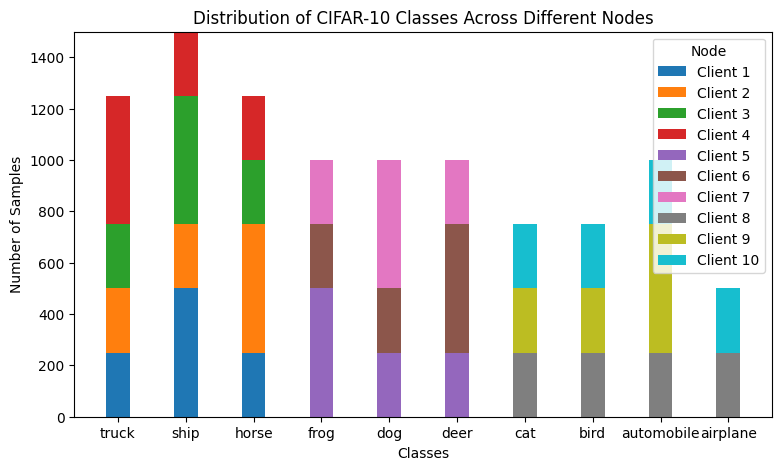

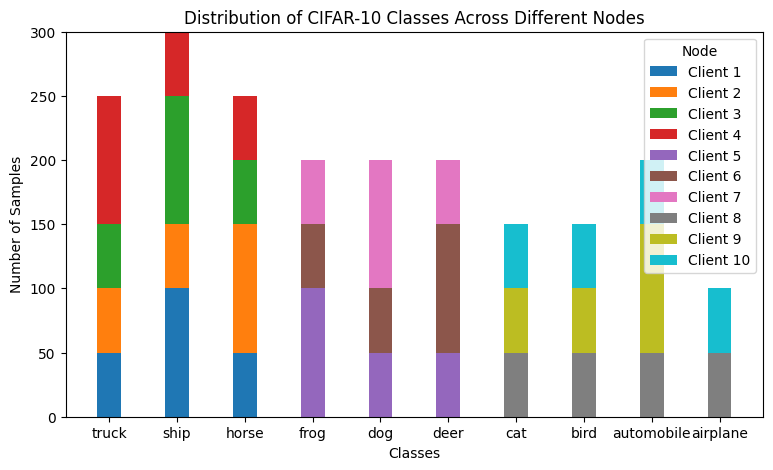

In [ ]:
Visualizer(trainloaders).plot_class_distribution()
Visualizer(testloaders).plot_class_distribution()

# **PLOT GRADIENTS**

In [ ]:
#--------------------------------
import copy

clusters=[]

initial = [i for i in range(num_clients)]
clusters.append(initial)

#client_IDs=[6,4,2,1,3]
def generate_initial_models(step,cluster,client_IDs,client_Models):
    print("-------------in initial genertaio")
    print("cluster", cluster)
    print("clientIDs", client_IDs)
    print("len_client_models(should be 10):",len(client_Models))
    list1=[]
    if step==0:
        for member in range(len(cluster)):
            list1.append(Net())
    else:
        for index in cluster:
            list1.append(client_Models[client_IDs.index(index)])
    return list1



## ---------------main
client_Models=[]
client_copy_models = []

for step in range(Clustering_period):
    client_copy_models=copy.deepcopy(client_Models)
    client_Models=[]
    print("\n\n---------Clustering step", step)
    FL_list=[]
    client_IDs=[]
    for cluster in clusters:
        for Id in cluster:
            client_IDs.append(Id)


        cluster_initial_models=generate_initial_models(step,cluster,client_IDs,client_copy_models)
        print(" ---in making new FL----cluster models len:", len(cluster_initial_models),"cluster IDs:", client_IDs)
        #print("lencluster", len(cluster_initial_models))
        f = FL(cluster,cluster_initial_models,FL_rounds, trainloaders, testloaders, Sensitivity_percentage)
        FL_list.append(f)
        #plot_accuracy(f.accuracies, str(cluster))



        for member in f.client_obj_list:
            client_Models.append(member.net)

        ## Save pytorch models for each client
        for cid in client_IDs:
          save_torch_model(client_Models[client_IDs.index(cid)], cid)
          save_model_param(client_Models[client_IDs.index(cid)], cid, step)

    print("----------------------Info befire clustering-------------")
    print("model_len:", len(client_Models))
    print("Client IDS:",client_IDs )

    start_cluster_time = datetime.now()
    clusters = Clustering(client_IDs, trainloaders, Sensitivity_percentage, cluster_number).Clusters
    end_cluster_time = datetime.now()
    exe_cluster_time = end_cluster_time - start_cluster_time
    with open(log_file, 'a') as f:
        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")

    print("new clustering:",clusters)





---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/10
node 0: train_acc: 0.65, test_acc:0.44
node 1: train_acc: 0.595, test_acc:0.6
node 2: train_acc: 0.637, test_acc:0.42
node 3: train_acc: 0.599, test_acc:0.56
node 4: train_acc: 0.463, test_acc:0.53
node 5: train_acc: 0.472, test_acc:0.38
node 6: train_acc: 0.504, test_acc:0.51
node 7: train_acc: 0.545, test_acc:0.435
node 8: train_acc: 0.67, test_acc:0.575
node 9: train_acc: 0.56, test_acc:0.435
model numbers: 10
time 0:00:44.343245
global acc: 0.4884999999999999

Round 2/10
node 0: train_acc: 0.647, test_acc:0.265
node 1: train_acc: 0.622, test_acc:0.5
node 2: train_acc: 0.611, test_acc:0.25
node 3: train_acc: 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cid is: 1
cid is: 2
cid is: 3

Round 1/10
node 0: train_acc: 0.803, test_acc:0.255
node 1: train_acc: 0.787, test_acc:0.565
node 2: train_acc: 0.803, test_acc:0.285
node 3: train_acc: 0.769, test_acc:0.55
model numbers: 4
time 0:00:17.980290
global acc: 0.41375

Round 2/10
node 0: train_acc: 0.809, test_acc:0.345
node 1: train_acc: 0.798, test_acc:0.525
node 2: train_acc: 0.772, test_acc:0.54
node 3: train_acc: 0.797, test_acc:0.54
model numbers: 4
time 0:00:35.438760
global acc: 0.48750000000000004

Round 3/10
node 0: train_acc: 0.811, test_acc:0.4
node 1: train_acc: 0.816, test_acc:0.5
node 2: train_acc: 0.792, test_acc:0.33
node 3: train_acc: 0.797, test_acc:0.63
model numbers: 4
time 0:00:52.541384
global acc: 0.46499999999999997

Round 4/10
node 0: train_acc: 0.836, test_acc:0.535
node 1: train_acc: 0.836, test_acc:0.545
node 2: train_acc: 0.832, test_acc:0.525
node 3: train_acc: 0.837, test_acc:0.55
model numbers: 4
time 0:01:09.750937
global acc: 0.5387500000000001

Round 5/10
n

KeyboardInterrupt: 

In [ ]:
#--------------------------------
import copy

clusters=[]

initial = [i for i in range(num_clients)]
clusters.append(initial)

#client_IDs=[6,4,2,1,3]
def generate_initial_models(step,cluster,client_IDs,client_Models):
    print("-------------in initial genertaio")
    print("cluster", cluster)
    print("clientIDs", client_IDs)
    print("len_client_models(should be 10):",len(client_Models))
    list1=[]
    if step==0:
        for member in range(len(cluster)):
            list1.append(Net())
    else:
        for index in cluster:
            list1.append(client_Models[client_IDs.index(index)])
    return list1



## ---------------main
client_Models=[]
client_copy_models = []

for step in range(Clustering_period):
    client_copy_models=copy.deepcopy(client_Models)
    client_Models=[]
    print("\n\n---------Clustering step", step)
    FL_list=[]
    client_IDs=[]
    for cluster in clusters:
        for Id in cluster:
            client_IDs.append(Id)


        cluster_initial_models=generate_initial_models(step,cluster,client_IDs,client_copy_models)
        print(" ---in making new FL----cluster models len:", len(cluster_initial_models),"cluster IDs:", client_IDs)
        #print("lencluster", len(cluster_initial_models))
        f = FL(cluster,cluster_initial_models,FL_rounds, trainloaders, testloaders, Sensitivity_percentage)
        FL_list.append(f)
        #plot_accuracy(f.accuracies, str(cluster))



        for member in f.client_obj_list:
            client_Models.append(member.net)

        ## Save pytorch models for each client
        for cid in client_IDs:
          save_torch_model(client_Models[client_IDs.index(cid)], cid)
          save_model_param(client_Models[client_IDs.index(cid)], cid, step)

    print("----------------------Info befire clustering-------------")
    print("model_len:", len(client_Models))
    print("Client IDS:",client_IDs )
    '''
    start_cluster_time = datetime.now()
    clusters = Clustering(client_IDs, trainloaders, Sensitivity_percentage, cluster_number).Clusters
    end_cluster_time = datetime.now()
    exe_cluster_time = end_cluster_time - start_cluster_time
    with open(log_file, 'a') as f:
        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")
    '''
    print("new clustering:",clusters)





---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/10


<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.8377777777777777, test_acc:0.9693333333333334
node 1: train_acc: 0.7711428571428571, test_acc:0.9691780821917808
node 2: train_acc: 0.7805714285714286, test_acc:1.0
node 3: train_acc: 0.9341333333333334, test_acc:0.9992
node 4: train_acc: 0.8682222222222222, test_acc:0.9986666666666667
node 5: train_acc: 0.9146666666666666, test_acc:0.9976
node 6: train_acc: 0.651375, test_acc:0.7501875468867217
node 7: train_acc: 0.8463333333333334, test_acc:1.0
node 8: train_acc: 0.675, test_acc:0.947
node 9: train_acc: 0.9298666666666666, test_acc:0.9992
model numbers: 10
time 0:00:36.128480
global acc: 0.9630365629078502

Round 2/10
node 0: train_acc: 0.6635555555555556, test_acc:0.6666666666666666
node 1: train_acc: 0.4165714285714286, test_acc:0.4280821917808219
node 2: train_acc: 0.7791428571428571, test_acc:1.0
node 3: train_acc: 0.19866666666666666, test_acc:0.2
node 4: train_acc: 0.3293333333333333, test_acc:0.3333333333333333
node 5: train_acc: 0.7049333333333333, test_a

In [ ]:
#--------------------------------
import copy

clusters=[]

initial = [i for i in range(num_clients)]
clusters.append(initial)

#client_IDs=[6,4,2,1,3]
def generate_initial_models(step,cluster,client_IDs,client_Models):
    print("-------------in initial genertaio")
    print("cluster", cluster)
    print("clientIDs", client_IDs)
    print("len_client_models(should be 10):",len(client_Models))
    list1=[]
    if step==0:
        for member in range(len(cluster)):
            list1.append(Net())
    else:
        for index in cluster:
            list1.append(client_Models[client_IDs.index(index)])
    return list1



## ---------------main
client_Models=[]
client_copy_models = []

for step in range(Clustering_period):
    client_copy_models=copy.deepcopy(client_Models)
    client_Models=[]
    print("\n\n---------Clustering step", step)
    FL_list=[]
    client_IDs=[]
    for cluster in clusters:
        for Id in cluster:
            client_IDs.append(Id)


        cluster_initial_models=generate_initial_models(step,cluster,client_IDs,client_copy_models)
        print(" ---in making new FL----cluster models len:", len(cluster_initial_models),"cluster IDs:", client_IDs)
        #print("lencluster", len(cluster_initial_models))
        f = FL(cluster,cluster_initial_models,FL_rounds, trainloaders, testloaders, Sensitivity_percentage)
        FL_list.append(f)
        #plot_accuracy(f.accuracies, str(cluster))



        for member in f.client_obj_list:
            client_Models.append(member.net)

        ## Save pytorch models for each client
        for cid in client_IDs:
          save_torch_model(client_Models[client_IDs.index(cid)], cid)
          save_model_param(client_Models[client_IDs.index(cid)], cid, step)

    print("----------------------Info befire clustering-------------")
    print("model_len:", len(client_Models))
    print("Client IDS:",client_IDs )

    start_cluster_time = datetime.now()
    clusters = Clustering(client_IDs, trainloaders, Sensitivity_percentage, cluster_number).Clusters
    end_cluster_time = datetime.now()
    exe_cluster_time = end_cluster_time - start_cluster_time
    with open(log_file, 'a') as f:
        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")

    print("new clustering:",clusters)





---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/10


<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.8235555555555556, test_acc:0.958
node 1: train_acc: 0.8497142857142858, test_acc:0.9691780821917808
node 2: train_acc: 0.8342857142857143, test_acc:1.0
node 3: train_acc: 0.9330666666666667, test_acc:1.0
node 4: train_acc: 0.7417777777777778, test_acc:0.9986666666666667
node 5: train_acc: 0.9084, test_acc:0.9976
node 6: train_acc: 0.71675, test_acc:0.7501875468867217
node 7: train_acc: 0.6823333333333333, test_acc:0.992
node 8: train_acc: 0.6683333333333333, test_acc:0.938
node 9: train_acc: 0.8713333333333333, test_acc:0.9992
model numbers: 10
time 0:00:36.561999
global acc: 0.960283229574517

Round 2/10
node 0: train_acc: 0.6644444444444444, test_acc:0.6666666666666666
node 1: train_acc: 0.42028571428571426, test_acc:0.4229452054794521
node 2: train_acc: 0.7774285714285715, test_acc:1.0
node 3: train_acc: 0.16826666666666668, test_acc:0.2
node 4: train_acc: 0.3188888888888889, test_acc:0.3333333333333333
node 5: train_acc: 0.2912, test_acc:0.996
node 6: train_acc

<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.9405555555555556, test_acc:0.958
node 8: train_acc: 0.4505, test_acc:0.471
model numbers: 2
time 0:00:09.294562
global acc: 0.7144999999999999

Round 2/10
node 0: train_acc: 0.9563333333333334, test_acc:0.9486666666666667
node 8: train_acc: 0.4686666666666667, test_acc:0.479
model numbers: 2
time 0:00:18.572960
global acc: 0.7138333333333333

Round 3/10
node 0: train_acc: 0.9555555555555556, test_acc:0.954
node 8: train_acc: 0.4646666666666667, test_acc:0.476
model numbers: 2
time 0:00:26.819005
global acc: 0.715

Round 4/10
node 0: train_acc: 0.9604444444444444, test_acc:0.95
node 8: train_acc: 0.4678333333333333, test_acc:0.48
model numbers: 2
time 0:00:36.216619
global acc: 0.715

Round 5/10
node 0: train_acc: 0.9612222222222222, test_acc:0.968
node 8: train_acc: 0.482, test_acc:0.488
model numbers: 2
time 0:00:45.661776
global acc: 0.728

Round 6/10
node 0: train_acc: 0.9635555555555556, test_acc:0.9666666666666667
node 8: train_acc: 0.48, test_acc:0.485
model 

<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.967, test_acc:0.972
node 8: train_acc: 0.4866666666666667, test_acc:0.495
model numbers: 2
time 0:00:09.241879
global acc: 0.7335

Round 2/10
node 0: train_acc: 0.9686666666666667, test_acc:0.9713333333333334
node 8: train_acc: 0.48966666666666664, test_acc:0.491
model numbers: 2
time 0:00:18.629800
global acc: 0.7311666666666667

Round 3/10
node 0: train_acc: 0.9676666666666667, test_acc:0.9713333333333334
node 8: train_acc: 0.489, test_acc:0.494
model numbers: 2
time 0:00:26.910286
global acc: 0.7326666666666667

Round 4/10
node 0: train_acc: 0.9692222222222222, test_acc:0.9726666666666667
node 8: train_acc: 0.48966666666666664, test_acc:0.494
model numbers: 2
time 0:00:36.116083
global acc: 0.7333333333333334

Round 5/10
node 0: train_acc: 0.9708888888888889, test_acc:0.9733333333333334
node 8: train_acc: 0.49, test_acc:0.488
model numbers: 2
time 0:00:45.541131
global acc: 0.7306666666666667

Round 6/10
node 0: train_acc: 0.9728888888888889, test_acc:0.97266666

<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.9752222222222222, test_acc:0.9713333333333334
node 8: train_acc: 0.49066666666666664, test_acc:0.493
model numbers: 2
time 0:00:08.112652
global acc: 0.7321666666666666

Round 2/10
node 0: train_acc: 0.9777777777777777, test_acc:0.978
node 8: train_acc: 0.49033333333333334, test_acc:0.494
model numbers: 2
time 0:00:17.467562
global acc: 0.736

Round 3/10
node 0: train_acc: 0.9765555555555555, test_acc:0.976
node 8: train_acc: 0.4905, test_acc:0.495
model numbers: 2
time 0:00:26.746600
global acc: 0.7355

Round 4/10
node 0: train_acc: 0.9766666666666667, test_acc:0.9786666666666667
node 8: train_acc: 0.49083333333333334, test_acc:0.496
model numbers: 2
time 0:00:34.890674
global acc: 0.7373333333333334

Round 5/10
node 0: train_acc: 0.978, test_acc:0.97
node 8: train_acc: 0.49216666666666664, test_acc:0.496
model numbers: 2
time 0:00:44.047838
global acc: 0.733

Round 6/10
node 0: train_acc: 0.9776666666666667, test_acc:0.978
node 8: train_acc: 0.49133333333333334, 

<ipython-input-23-e53d7605a93b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


node 0: train_acc: 0.979, test_acc:0.968
node 8: train_acc: 0.49116666666666664, test_acc:0.495
model numbers: 2
time 0:00:09.259672
global acc: 0.7315

Round 2/10
node 0: train_acc: 0.9771111111111112, test_acc:0.9806666666666667
node 8: train_acc: 0.49416666666666664, test_acc:0.495
model numbers: 2
time 0:00:17.572686
global acc: 0.7378333333333333

Round 3/10
node 0: train_acc: 0.9785555555555555, test_acc:0.9793333333333333
node 8: train_acc: 0.49233333333333335, test_acc:0.496
model numbers: 2
time 0:00:26.974704
global acc: 0.7376666666666667

Round 4/10
node 0: train_acc: 0.9773333333333334, test_acc:0.976
node 8: train_acc: 0.49283333333333335, test_acc:0.496
model numbers: 2
time 0:00:36.441367
global acc: 0.736

Round 5/10
node 0: train_acc: 0.9802222222222222, test_acc:0.9786666666666667
node 8: train_acc: 0.4915, test_acc:0.496
model numbers: 2
time 0:00:44.672943
global acc: 0.7373333333333334

Round 6/10
node 0: train_acc: 0.978, test_acc:0.9773333333333334
node 8: train

# **NEW PARTITIONING**

In [ ]:

import torch.utils.data as data
import torch
from PIL import Image
import numpy as np
from torchvision.datasets import MNIST, CIFAR10, SVHN, FashionMNIST, CIFAR100, ImageFolder, DatasetFolder, utils
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_file_from_google_drive, check_integrity
from functools import partial
from typing import Optional, Callable
from torch.utils.model_zoo import tqdm
import PIL
import tarfile
import torchvision

import os
import os.path
import logging
import torchvision.datasets.utils as utils

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

class CustomTensorDataset(data.TensorDataset):
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors) + (index,)


class MNIST_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = MNIST(self.root, self.train, self.transform, self.target_transform, self.download)

        # if self.train:
        #     data = mnist_dataobj.train_data
        #     target = mnist_dataobj.train_labels
        # else:
        #     data = mnist_dataobj.test_data
        #     target = mnist_dataobj.test_labels

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        # print("mnist img:", img)
        # print("mnist target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

class FashionMNIST_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = FashionMNIST(self.root, self.train, self.transform, self.target_transform, self.download)

        # if self.train:
        #     data = mnist_dataobj.train_data
        #     target = mnist_dataobj.train_labels
        # else:
        #     data = mnist_dataobj.test_data
        #     target = mnist_dataobj.test_labels

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        # print("mnist img:", img)
        # print("mnist target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

class SVHN_custom(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        if self.train is True:
            # svhn_dataobj1 = SVHN(self.root, 'train', self.transform, self.target_transform, self.download)
            # svhn_dataobj2 = SVHN(self.root, 'extra', self.transform, self.target_transform, self.download)
            # data = np.concatenate((svhn_dataobj1.data, svhn_dataobj2.data), axis=0)
            # target = np.concatenate((svhn_dataobj1.labels, svhn_dataobj2.labels), axis=0)

            svhn_dataobj = SVHN(self.root, 'train', self.transform, self.target_transform, self.download)
            data = svhn_dataobj.data
            target = svhn_dataobj.labels
        else:
            svhn_dataobj = SVHN(self.root, 'test', self.transform, self.target_transform, self.download)
            data = svhn_dataobj.data
            target = svhn_dataobj.labels

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]
        # print("svhn data:", data)
        # print("len svhn data:", len(data))
        # print("type svhn data:", type(data))
        # print("svhn target:", target)
        # print("type svhn target", type(target))
        return data, target

    # def truncate_channel(self, index):
    #     for i in range(index.shape[0]):
    #         gs_index = index[i]
    #         self.data[gs_index, :, :, 1] = 0.0
    #         self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # print("svhn img:", img)
        # print("svhn target:", target)
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


# torchvision CelebA
class CelebA_custom(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        ("0B7EVK8r0v71pZjFTYXZWM3FlRnM", "00d2c5bc6d35e252742224ab0c1e8fcb", "img_align_celeba.zip"),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        ("0B7EVK8r0v71pblRyaVFSWGxPY0U", "75e246fa4810816ffd6ee81facbd244c", "list_attr_celeba.txt"),
        ("1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS", "32bd1bd63d3c78cd57e08160ec5ed1e2", "identity_CelebA.txt"),
        ("0B7EVK8r0v71pbThiMVRxWXZ4dU0", "00566efa6fedff7a56946cd1c10f1c16", "list_bbox_celeba.txt"),
        ("0B7EVK8r0v71pd0FJY3Blby1HUTQ", "cc24ecafdb5b50baae59b03474781f8c", "list_landmarks_align_celeba.txt"),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        ("0B7EVK8r0v71pY0NSMzRuSXJEVkk", "d32c9cbf5e040fd4025c592c306e6668", "list_eval_partition.txt"),
    ]

    def __init__(self, root, dataidxs=None, split="train", target_type="attr", transform=None,
                 target_transform=None, download=False):
        import pandas
        super(CelebA_custom, self).__init__(root, transform=transform,
                                     target_transform=target_transform)
        self.split = split
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError('target_transform is specified but target_type is empty')

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[split.lower()]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(fn("list_eval_partition.txt"), delim_whitespace=True, header=None, index_col=0)
        identity = pandas.read_csv(fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0)
        bbox = pandas.read_csv(fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0)
        landmarks_align = pandas.read_csv(fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1)
        attr = pandas.read_csv(fn("list_attr_celeba.txt"), delim_whitespace=True, header=1)

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)
        self.gender_index = self.attr_names.index('Male')
        self.dataidxs = dataidxs
        if self.dataidxs is None:
            self.target = self.attr[:, self.gender_index:self.gender_index + 1].reshape(-1)
        else:
            self.target = self.attr[self.dataidxs, self.gender_index:self.gender_index + 1].reshape(-1)

    def _check_integrity(self):
        for (_, md5, filename) in self.file_list:
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False

        # Should check a hash of the images
        return os.path.isdir(os.path.join(self.root, self.base_folder, "img_align_celeba"))

    def download(self):
        import zipfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        for (file_id, md5, filename) in self.file_list:
            download_file_from_google_drive(file_id, os.path.join(self.root, self.base_folder), filename, md5)

        with zipfile.ZipFile(os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r") as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        if self.dataidxs is None:
            X = PIL.Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[index]))

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[index, self.gender_index])
                elif t == "identity":
                    target.append(self.identity[index, 0])
                elif t == "bbox":
                    target.append(self.bbox[index, :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[index, :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError("Target type \"{}\" is not recognized.".format(t))
        else:
            X = PIL.Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[self.dataidxs[index]]))

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[self.dataidxs[index], self.gender_index])
                elif t == "identity":
                    target.append(self.identity[self.dataidxs[index], 0])
                elif t == "bbox":
                    target.append(self.bbox[self.dataidxs[index], :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[self.dataidxs[index], :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError("Target type \"{}\" is not recognized.".format(t))

        if self.transform is not None:
            X = self.transform(X)
        #print("target[0]:", target[0])
        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None
        #print("celeba target:", target)
        return X, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.attr)
        else:
            return len(self.dataidxs)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return '\n'.join(lines).format(**self.__dict__)



class CIFAR10_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(self.root, self.train, self.transform, self.target_transform, self.download)

        data = cifar_dataobj.data
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

def gen_bar_updater() -> Callable[[int, int, int], None]:
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update


def download_url(url: str, root: str, filename: Optional[str] = None, md5: Optional[str] = None) -> None:
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    # check if file is already present locally
    if check_integrity(fpath, md5):
        print('Using downloaded and verified file: ' + fpath)
    else:   # download the file
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(
                url, fpath,
                reporthook=gen_bar_updater()
            )
        except (urllib.error.URLError, IOError) as e:  # type: ignore[attr-defined]
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(
                    url, fpath,
                    reporthook=gen_bar_updater()
                )
            else:
                raise e
        # check integrity of downloaded file
        if not check_integrity(fpath, md5):
            raise RuntimeError("File not found or corrupted.")

def _is_tarxz(filename: str) -> bool:
    return filename.endswith(".tar.xz")


def _is_tar(filename: str) -> bool:
    return filename.endswith(".tar")


def _is_targz(filename: str) -> bool:
    return filename.endswith(".tar.gz")


def _is_tgz(filename: str) -> bool:
    return filename.endswith(".tgz")


def _is_gzip(filename: str) -> bool:
    return filename.endswith(".gz") and not filename.endswith(".tar.gz")


def _is_zip(filename: str) -> bool:
    return filename.endswith(".zip")


def extract_archive(from_path: str, to_path: Optional[str] = None, remove_finished: bool = False) -> None:
    if to_path is None:
        to_path = os.path.dirname(from_path)

    if _is_tar(from_path):
        with tarfile.open(from_path, 'r') as tar:
            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)


            safe_extract(tar, path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, 'r:gz') as tar:
            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)


            safe_extract(tar, path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, 'r:xz') as tar:
            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)


            safe_extract(tar, path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(to_path, os.path.splitext(os.path.basename(from_path))[0])
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, 'r') as z:
            z.extractall(to_path)
    else:
        raise ValueError("Extraction of {} not supported".format(from_path))

    if remove_finished:
        os.remove(from_path)


def download_and_extract_archive(
    url: str,
    download_root: str,
    extract_root: Optional[str] = None,
    filename: Optional[str] = None,
    md5: Optional[str] = None,
    remove_finished: bool = False,
) -> None:
    download_root = os.path.expanduser(download_root)
    if extract_root is None:
        extract_root = download_root
    if not filename:
        filename = os.path.basename(url)

    download_url(url, download_root, filename, md5)

    archive = os.path.join(download_root, filename)
    print("Extracting {} to {}".format(archive, extract_root))
    extract_archive(archive, extract_root, remove_finished)

class FEMNIST(MNIST):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """
    resources = [
        ('https://raw.githubusercontent.com/tao-shen/FEMNIST_pytorch/master/femnist.tar.gz',
         '59c65cec646fc57fe92d27d83afdf0ed')]

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None,
                 download=False):
        super(MNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train
        self.dataidxs = dataidxs

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        self.data, self.targets, self.users_index = torch.load(os.path.join(self.processed_folder, data_file))

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]


    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode='F')
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def download(self):
        """Download the FEMNIST data if it doesn't exist in processed_folder already."""
        import shutil

        if self._check_exists():
            return

        mkdirs(self.raw_folder)
        mkdirs(self.processed_folder)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)

        # process and save as torch files
        print('Processing...')
        shutil.move(os.path.join(self.raw_folder, self.training_file), self.processed_folder)
        shutil.move(os.path.join(self.raw_folder, self.test_file), self.processed_folder)

    def __len__(self):
        return len(self.data)

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]+os.path.splitext(os.path.basename(url))[1]))
            for url, _ in self.resources
        )


class Generated(MNIST):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None,
                 download=False):
        super(MNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train
        self.dataidxs = dataidxs

        if self.train:
            self.data = np.load("data/generated/X_train.npy")
            self.targets = np.load("data/generated/y_train.npy")
        else:
            self.data = np.load("data/generated/X_test.npy")
            self.targets = np.load("data/generated/y_test.npy")

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]


    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)



class genData(MNIST):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    def __getitem__(self,index):
        data, target = self.data[index], self.targets[index]
        return data, target
    def __len__(self):
        return len(self.data)

class CIFAR100_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR100(self.root, self.train, self.transform, self.target_transform, self.download)

        if torchvision.__version__ == '0.2.1':
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(cifar_dataobj.train_labels)
            else:
                data, target = cifar_dataobj.test_data, np.array(cifar_dataobj.test_labels)
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)




class ImageFolder_custom(DatasetFolder):
    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=None):
        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        imagefolder_obj = ImageFolder(self.root, self.transform, self.target_transform)
        self.loader = imagefolder_obj.loader
        if self.dataidxs is not None:
            self.samples = np.array(imagefolder_obj.samples)[self.dataidxs]
        else:
            self.samples = np.array(imagefolder_obj.samples)

    def __getitem__(self, index):
        path = self.samples[index][0]
        target = self.samples[index][1]
        target = int(target)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.samples)
        else:
            return len(self.dataidxs)


In [ ]:
import os
import logging
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.functional as F
import random
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
import copy

from math import sqrt

import torch.nn as nn

import torch.optim as optim
import torchvision.utils as vutils
import time
import random

import sklearn.datasets as sk
from sklearn.datasets import load_svmlight_file

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass

def load_mnist_data(datadir):

    transform = transforms.Compose([transforms.ToTensor()])

    mnist_train_ds = MNIST_truncated(datadir, train=True, download=True, transform=transform)
    mnist_test_ds = MNIST_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target

    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()

    return (X_train, y_train, X_test, y_test)

def load_fmnist_data(datadir):

    transform = transforms.Compose([transforms.ToTensor()])

    mnist_train_ds = FashionMNIST_truncated(datadir, train=True, download=True, transform=transform)
    mnist_test_ds = FashionMNIST_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target

    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()

    return (X_train, y_train, X_test, y_test)

def load_svhn_data(datadir):

    transform = transforms.Compose([transforms.ToTensor()])

    svhn_train_ds = SVHN_custom(datadir, train=True, download=True, transform=transform)
    svhn_test_ds = SVHN_custom(datadir, train=False, download=True, transform=transform)

    X_train, y_train = svhn_train_ds.data, svhn_train_ds.target
    X_test, y_test = svhn_test_ds.data, svhn_test_ds.target

    # X_train = X_train.data.numpy()
    # y_train = y_train.data.numpy()
    # X_test = X_test.data.numpy()
    # y_test = y_test.data.numpy()

    return (X_train, y_train, X_test, y_test)


def load_cifar10_data(datadir):

    transform = transforms.Compose([
        transforms.ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    cifar10_train_ds = CIFAR10_truncated(datadir, train=True, download=True, transform=transform)
    cifar10_test_ds = CIFAR10_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)

def load_celeba_data(datadir):

    transform = transforms.Compose([transforms.ToTensor()])

    celeba_train_ds = CelebA_custom(datadir, split='train', target_type="attr", download=True, transform=transform)
    celeba_test_ds = CelebA_custom(datadir, split='test', target_type="attr", download=True, transform=transform)

    gender_index = celeba_train_ds.attr_names.index('Male')
    y_train =  celeba_train_ds.attr[:,gender_index:gender_index+1].reshape(-1)
    y_test = celeba_test_ds.attr[:,gender_index:gender_index+1].reshape(-1)

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (None, y_train, None, y_test)

def load_femnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    mnist_train_ds = FEMNIST(datadir, train=True, transform=transform, download=True)
    mnist_test_ds = FEMNIST(datadir, train=False, transform=transform, download=True)

    X_train, y_train, u_train = mnist_train_ds.data, mnist_train_ds.targets, mnist_train_ds.users_index
    X_test, y_test, u_test = mnist_test_ds.data, mnist_test_ds.targets, mnist_test_ds.users_index

    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    u_train = np.array(u_train)
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    u_test = np.array(u_test)

    return (X_train, y_train, u_train, X_test, y_test, u_test)

def load_cifar100_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])

    cifar100_train_ds = CIFAR100_truncated(datadir, train=True, download=True, transform=transform)
    cifar100_test_ds = CIFAR100_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = cifar100_train_ds.data, cifar100_train_ds.target
    X_test, y_test = cifar100_test_ds.data, cifar100_test_ds.target

    # y_train = y_train.numpy()
    # y_test = y_test.numpy()

    return (X_train, y_train, X_test, y_test)


def load_tinyimagenet_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    xray_train_ds = ImageFolder_custom(datadir+'./train/', transform=transform)
    xray_test_ds = ImageFolder_custom(datadir+'./val/', transform=transform)

    X_train, y_train = np.array([s[0] for s in xray_train_ds.samples]), np.array([int(s[1]) for s in xray_train_ds.samples])
    X_test, y_test = np.array([s[0] for s in xray_test_ds.samples]), np.array([int(s[1]) for s in xray_test_ds.samples])

    return (X_train, y_train, X_test, y_test)

def record_net_data_stats(y_train, net_dataidx_map, logdir):

    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.4):
    #np.random.seed(2020)
    #torch.manual_seed(2020)

    if dataset == 'mnist':
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == 'fmnist':
        X_train, y_train, X_test, y_test = load_fmnist_data(datadir)
    elif dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == 'svhn':
        X_train, y_train, X_test, y_test = load_svhn_data(datadir)
    elif dataset == 'celeba':
        X_train, y_train, X_test, y_test = load_celeba_data(datadir)
    elif dataset == 'femnist':
        X_train, y_train, u_train, X_test, y_test, u_test = load_femnist_data(datadir)
    elif dataset == 'cifar100':
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == 'tinyimagenet':
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)
    elif dataset == 'generated':
        X_train, y_train = [], []
        for loc in range(4):
            for i in range(1000):
                p1 = random.random()
                p2 = random.random()
                p3 = random.random()
                if loc > 1:
                    p2 = -p2
                if loc % 2 ==1:
                    p3 = -p3
                if i % 2 == 0:
                    X_train.append([p1, p2, p3])
                    y_train.append(0)
                else:
                    X_train.append([-p1, -p2, -p3])
                    y_train.append(1)
        X_test, y_test = [], []
        for i in range(1000):
            p1 = random.random() * 2 - 1
            p2 = random.random() * 2 - 1
            p3 = random.random() * 2 - 1
            X_test.append([p1, p2, p3])
            if p1>0:
                y_test.append(0)
            else:
                y_test.append(1)
        X_train = np.array(X_train, dtype=np.float32)
        X_test = np.array(X_test, dtype=np.float32)
        y_train = np.array(y_train, dtype=np.int32)
        y_test = np.array(y_test, dtype=np.int64)
        idxs = np.linspace(0,3999,4000,dtype=np.int64)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}
        mkdirs("data/generated/")
        np.save("data/generated/X_train.npy",X_train)
        np.save("data/generated/X_test.npy",X_test)
        np.save("data/generated/y_train.npy",y_train)
        np.save("data/generated/y_test.npy",y_test)

    #elif dataset == 'covtype':
    #    cov_type = sk.fetch_covtype('./data')
    #    num_train = int(581012 * 0.75)
    #    idxs = np.random.permutation(581012)
    #    X_train = np.array(cov_type['data'][idxs[:num_train]], dtype=np.float32)
    #    y_train = np.array(cov_type['target'][idxs[:num_train]], dtype=np.int32) - 1
    #    X_test = np.array(cov_type['data'][idxs[num_train:]], dtype=np.float32)
    #    y_test = np.array(cov_type['target'][idxs[num_train:]], dtype=np.int32) - 1
    #    mkdirs("data/generated/")
    #    np.save("data/generated/X_train.npy",X_train)
    #    np.save("data/generated/X_test.npy",X_test)
    #    np.save("data/generated/y_train.npy",y_train)
    #    np.save("data/generated/y_test.npy",y_test)

    elif dataset in ('rcv1', 'SUSY', 'covtype'):
        X_train, y_train = load_svmlight_file(datadir+dataset)
        X_train = X_train.todense()
        num_train = int(X_train.shape[0] * 0.75)
        if dataset == 'covtype':
            y_train = y_train-1
        else:
            y_train = (y_train+1)/2
        idxs = np.random.permutation(X_train.shape[0])

        X_test = np.array(X_train[idxs[num_train:]], dtype=np.float32)
        y_test = np.array(y_train[idxs[num_train:]], dtype=np.int32)
        X_train = np.array(X_train[idxs[:num_train]], dtype=np.float32)
        y_train = np.array(y_train[idxs[:num_train]], dtype=np.int32)

        mkdirs("data/generated/")
        np.save("data/generated/X_train.npy",X_train)
        np.save("data/generated/X_test.npy",X_test)
        np.save("data/generated/y_train.npy",y_train)
        np.save("data/generated/y_test.npy",y_test)

    elif dataset in ('a9a'):
        X_train, y_train = load_svmlight_file(datadir+"a9a")
        X_test, y_test = load_svmlight_file(datadir+"a9a.t")
        X_train = X_train.todense()
        X_test = X_test.todense()
        X_test = np.c_[X_test, np.zeros((len(y_test), X_train.shape[1] - np.size(X_test[0, :])))]

        X_train = np.array(X_train, dtype=np.float32)
        X_test = np.array(X_test, dtype=np.float32)
        y_train = (y_train+1)/2
        y_test = (y_test+1)/2
        y_train = np.array(y_train, dtype=np.int32)
        y_test = np.array(y_test, dtype=np.int32)

        mkdirs("data/generated/")
        np.save("data/generated/X_train.npy",X_train)
        np.save("data/generated/X_test.npy",X_test)
        np.save("data/generated/y_train.npy",y_train)
        np.save("data/generated/y_test.npy",y_test)


    n_train = y_train.shape[0]

    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}


    elif partition == "noniid-labeldir":
        print("here nowwww")
        min_size = 0
        min_require_size = 10
        K = 10
        if dataset in ('celeba', 'covtype', 'a9a', 'rcv1', 'SUSY'):
            K = 2
            # min_require_size = 100
        if dataset == 'cifar100':
            K = 100
        elif dataset == 'tinyimagenet':
            K = 200

        N = y_train.shape[0]
        #np.random.seed(2020)
        net_dataidx_map = {}

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]
                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))
                # logger.info("proportions1: ", proportions)
                # logger.info("sum pro1:", np.sum(proportions))
                ## Balance
                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
                # logger.info("proportions2: ", proportions)
                proportions = proportions / proportions.sum()
                # logger.info("proportions3: ", proportions)
                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
                # logger.info("proportions4: ", proportions)
                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
                min_size = min([len(idx_j) for idx_j in idx_batch])
                # if K == 2 and n_parties <= 10:
                #     if np.min(proportions) < 200:
                #         min_size = 0
                #         break


        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]
        print("map",net_dataidx_map)

    elif partition > "noniid-#label0" and partition <= "noniid-#label9":
        num = eval(partition[13:])
        if dataset in ('celeba', 'covtype', 'a9a', 'rcv1', 'SUSY'):
            num = 1
            K = 2
        else:
            K = 10
        if dataset == "cifar100":
            K = 100
        elif dataset == "tinyimagenet":
            K = 200
        if num == 10:
            net_dataidx_map ={i:np.ndarray(0,dtype=np.int64) for i in range(n_parties)}
            for i in range(10):
                idx_k = np.where(y_train==i)[0]
                np.random.shuffle(idx_k)
                split = np.array_split(idx_k,n_parties)
                for j in range(n_parties):
                    net_dataidx_map[j]=np.append(net_dataidx_map[j],split[j])
        else:
            times=[0 for i in range(K)]
            contain=[]
            for i in range(n_parties):
                current=[i%K]
                times[i%K]+=1
                j=1
                while (j<num):
                    ind=random.randint(0,K-1)
                    if (ind not in current):
                        j=j+1
                        current.append(ind)
                        times[ind]+=1
                contain.append(current)
            net_dataidx_map ={i:np.ndarray(0,dtype=np.int64) for i in range(n_parties)}
            test_dataidx_map ={i:np.ndarray(0,dtype=np.int64) for i in range(n_parties)}
            for i in range(K):
                idx_k = np.where(y_train==i)[0]
                idx_t = np.where(y_test==i)[0]
                np.random.shuffle(idx_k)
                np.random.shuffle(idx_t)
                split = np.array_split(idx_k,times[i])
                splitt = np.array_split(idx_t,times[i])
                ids=0
                for j in range(n_parties):
                    if i in contain[j]:
                        net_dataidx_map[j]=np.append(net_dataidx_map[j],split[ids])
                        test_dataidx_map[j]=np.append(test_dataidx_map[j],splitt[ids])
                        ids+=1

    elif partition == "iid-diff-quantity":
        idxs = np.random.permutation(n_train)
        min_size = 0
        while min_size < 10:
            proportions = np.random.dirichlet(np.repeat(beta, n_parties))
            proportions = proportions/proportions.sum()
            min_size = np.min(proportions*len(idxs))
        proportions = (np.cumsum(proportions)*len(idxs)).astype(int)[:-1]
        batch_idxs = np.split(idxs,proportions)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}

    elif partition == "mixed":
        min_size = 0
        min_require_size = 10
        K = 10
        if dataset in ('celeba', 'covtype', 'a9a', 'rcv1', 'SUSY'):
            K = 2
            # min_require_size = 100

        N = y_train.shape[0]
        net_dataidx_map = {}

        times=[1 for i in range(10)]
        contain=[]
        for i in range(n_parties):
            current=[i%K]
            j=1
            while (j<2):
                ind=random.randint(0,K-1)
                if (ind not in current and times[ind]<2):
                    j=j+1
                    current.append(ind)
                    times[ind]+=1
            contain.append(current)
        net_dataidx_map ={i:np.ndarray(0,dtype=np.int64) for i in range(n_parties)}


        min_size = 0
        while min_size < 10:
            proportions = np.random.dirichlet(np.repeat(beta, n_parties))
            proportions = proportions/proportions.sum()
            min_size = np.min(proportions*n_train)

        for i in range(K):
            idx_k = np.where(y_train==i)[0]
            np.random.shuffle(idx_k)

            proportions_k = np.random.dirichlet(np.repeat(beta, 2))
            #proportions_k = np.ndarray(0,dtype=np.float64)
            #for j in range(n_parties):
            #    if i in contain[j]:
            #        proportions_k=np.append(proportions_k ,proportions[j])

            proportions_k = (np.cumsum(proportions_k)*len(idx_k)).astype(int)[:-1]

            split = np.split(idx_k, proportions_k)
            ids=0
            for j in range(n_parties):
                if i in contain[j]:
                    net_dataidx_map[j]=np.append(net_dataidx_map[j],split[ids])
                    ids+=1

    elif partition == "real" and dataset == "femnist":
        num_user = u_train.shape[0]
        user = np.zeros(num_user+1,dtype=np.int32)
        for i in range(1,num_user+1):
            user[i] = user[i-1] + u_train[i-1]
        no = np.random.permutation(num_user)
        batch_idxs = np.array_split(no, n_parties)
        net_dataidx_map = {i:np.zeros(0,dtype=np.int32) for i in range(n_parties)}
        for i in range(n_parties):
            for j in batch_idxs[i]:
                net_dataidx_map[i]=np.append(net_dataidx_map[i], np.arange(user[j], user[j+1]))

    elif partition == "transfer-from-femnist":
        stat = np.load("femnist-dis.npy")
        n_total = stat.shape[0]
        chosen = np.random.permutation(n_total)[:n_parties]
        stat = stat[chosen,:]

        if dataset in ('celeba', 'covtype', 'a9a', 'rcv1', 'SUSY'):
            K = 2
        else:
            K = 10

        N = y_train.shape[0]
        #np.random.seed(2020)
        net_dataidx_map = {}

        idx_batch = [[] for _ in range(n_parties)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = stat[:,k]
            # logger.info("proportions2: ", proportions)
            proportions = proportions / proportions.sum()
            # logger.info("proportions3: ", proportions)
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            # logger.info("proportions4: ", proportions)
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]


        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    elif partition == "transfer-from-criteo":
        stat0 = np.load("criteo-dis.npy")

        n_total = stat0.shape[0]
        flag=True
        while (flag):
            chosen = np.random.permutation(n_total)[:n_parties]
            stat = stat0[chosen,:]
            check = [0 for i in range(10)]
            for ele in stat:
                for j in range(10):
                    if ele[j]>0:
                        check[j]=1
            flag=False
            for i in range(10):
                if check[i]==0:
                    flag=True
                    break


        if dataset in ('celeba', 'covtype', 'a9a', 'rcv1', 'SUSY'):
            K = 2
            stat[:,0]=np.sum(stat[:,:5],axis=1)
            stat[:,1]=np.sum(stat[:,5:],axis=1)
        else:
            K = 10

        N = y_train.shape[0]
        #np.random.seed(2020)
        net_dataidx_map = {}

        idx_batch = [[] for _ in range(n_parties)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = stat[:,k]
            # logger.info("proportions2: ", proportions)
            proportions = proportions / proportions.sum()
            # logger.info("proportions3: ", proportions)
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            # logger.info("proportions4: ", proportions)
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]


        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return (X_train, y_train, X_test, y_test, net_dataidx_map, test_dataidx_map, traindata_cls_counts)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., net_id=None, total=0):
        self.std = std
        self.mean = mean
        self.net_id = net_id
        self.num = int(sqrt(total))
        if self.num * self.num < total:
            self.num = self.num + 1

    def __call__(self, tensor):
        if self.net_id is None:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            tmp = torch.randn(tensor.size())
            filt = torch.zeros(tensor.size())
            size = int(28 / self.num)
            row = int(self.net_id / size)
            col = self.net_id % size
            for i in range(size):
                for j in range(size):
                    filt[:,row*size+i,col*size+j] = 1
            tmp = tmp * filt
            return tensor + tmp * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def get_dataloader(dataset, datadir, train_bs, test_bs, dataidxs=None, testidxs=None, noise_level=0, net_id=None, total=0):
    if dataset in ('mnist', 'femnist', 'fmnist', 'cifar10', 'svhn', 'generated', 'covtype', 'a9a', 'rcv1', 'SUSY', 'cifar100', 'tinyimagenet'):
        if dataset == 'mnist':
            dl_obj = MNIST_truncated

            transform_train = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])

        elif dataset == 'femnist':
            dl_obj = FEMNIST
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])

        elif dataset == 'fmnist':
            dl_obj = FashionMNIST_truncated
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])

        elif dataset == 'svhn':
            dl_obj = SVHN_custom
            transform_train = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                AddGaussianNoise(0., noise_level, net_id, total)])


        elif dataset == 'cifar10':
            print("in cifar10")
            dl_obj = CIFAR10_truncated

            transform_train = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: F.pad(
                    Variable(x.unsqueeze(0), requires_grad=False),
                    (4, 4, 4, 4), mode='reflect').data.squeeze()),
                transforms.ToPILImage(),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                AddGaussianNoise(0., noise_level, net_id, total)
            ])
            # data prep for test set
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                AddGaussianNoise(0., noise_level, net_id, total)])

        elif dataset == 'cifar100':
            print("in 100")
            dl_obj = CIFAR100_truncated

            normalize = transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                             std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404])
            # transform_train = transforms.Compose([
            #     transforms.RandomCrop(32),
            #     transforms.RandomHorizontalFlip(),
            #     transforms.ToTensor(),
            #     normalize
            # ])
            transform_train = transforms.Compose([
                # transforms.ToPILImage(),
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                normalize
            ])
            # data prep for test set
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize])
        elif dataset == 'tinyimagenet':
            dl_obj = ImageFolder_custom
            transform_train = transforms.Compose([
                transforms.Resize(32),
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
            transform_test = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

        else:
            dl_obj = Generated
            transform_train = None
            transform_test = None


        if dataset == "tinyimagenet":
            train_ds = dl_obj(datadir+'./train/', dataidxs=dataidxs, transform=transform_train)
            test_ds = dl_obj(datadir+'./val/', transform=transform_test)
        else:
            print("dir", datadir)
            train_ds = dl_obj(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
            test_ds = dl_obj(datadir, dataidxs=testidxs, train=False, transform=transform_test, download=True)

        train_dl = data.DataLoader(dataset=train_ds, batch_size=train_bs, shuffle=True, drop_last=False)
        test_dl = data.DataLoader(dataset=test_ds, batch_size=test_bs, shuffle=False, drop_last=False)
        print(train_ds, "train ds")

    return train_dl, test_dl, train_ds, test_ds






In [ ]:
def get_loaders(num_clients):

  X_train, y_train, X_test, y_test, net_dataidx_map, test_dataidx_map, traindata_cls_counts = partition_data(dataset='fmnist', datadir='./data/', logdir='./logs/', partition='noniid-#label2', n_parties=10, beta=0.5)
  print("shapes", X_train.shape, y_train.shape)
  trainloaders = []
  testloaders = []
  for client_id in range(num_clients):

    dataidxs = net_dataidx_map[client_id]
    testidxs = test_dataidx_map[client_id]

    train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(dataset='fmnist', datadir='./data/', train_bs=64, test_bs=64, dataidxs=dataidxs, testidxs=testidxs)
    trainloaders.append(train_dl_local)
    testloaders.append(test_dl_local)

  return trainloaders, testloaders


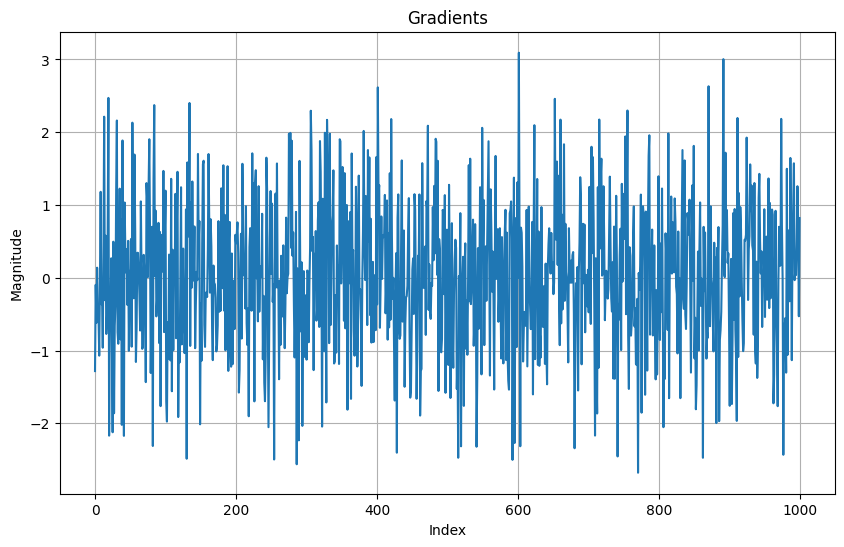

'\ngradients = np.random.randn(1000)\nprint("grads", len(gradients))\n\nvisualize_gradients_and_stats(gradients)\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


def plot_gradient_spectrum(gradients):

  plt.figure(figsize=(10,6))
  plt.plot(range(len(gradients)), gradients)
  plt.xlabel("Index")
  plt.ylabel("Magnitude")
  plt.title("Gradients")
  plt.grid(True)
  plt.show()

gradients = np.random.randn(1000)
plot_gradient_spectrum(gradients)

def visualize_gradients_and_stats(gradients):
  bin_width = 0.0005
  bins = np.arange(min(gradients), max(gradients) + bin_width, bin_width)
  hist, bin_edges = np.histogram(gradients, bins=bins)


  grad_skewness = skew(gradients)
  grad_kurtosis = kurtosis(gradients)


  plt.figure(figsize=(7,5))
  plt.bar(bin_edges[:-1], hist, width=bin_width, edgecolor='black', align='edge')
  plt.xlabel("Gradient Vlaue")
  plt.ylabel("Frequency")
  plt.title("Gradient Distribution\ Skewness: {:.2f}, Kurtosis: {:.2f}".format(grad_skewness, grad_kurtosis))


  plt.show()
  return grad_skewness, grad_kurtosis
'''
gradients = np.random.randn(1000)
print("grads", len(gradients))

visualize_gradients_and_stats(gradients)
'''

# **MAIN**

# **PLOT ACCURACIES**

In [ ]:
def plot_accuracy(accuracies, title: str):
  print(accuracies)
  fl_rounds = accuracies.keys()
  print("rounds", fl_rounds)
  accuracy_list = accuracies.values()

  plt.figure(figsize=(10,6))
  plt.plot(fl_rounds, accuracy_list)
  plt.xlabel("FL Rounds")
  plt.ylabel("Accuracy Magnitude")
  plt.title(title)
  plt.grid(True)
  plt.show()